<a href="https://colab.research.google.com/github/olgaperich/Introduction_to_Causal_Inference_final_project/blob/main/Introduction_to_Causal_Inference_final_project_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

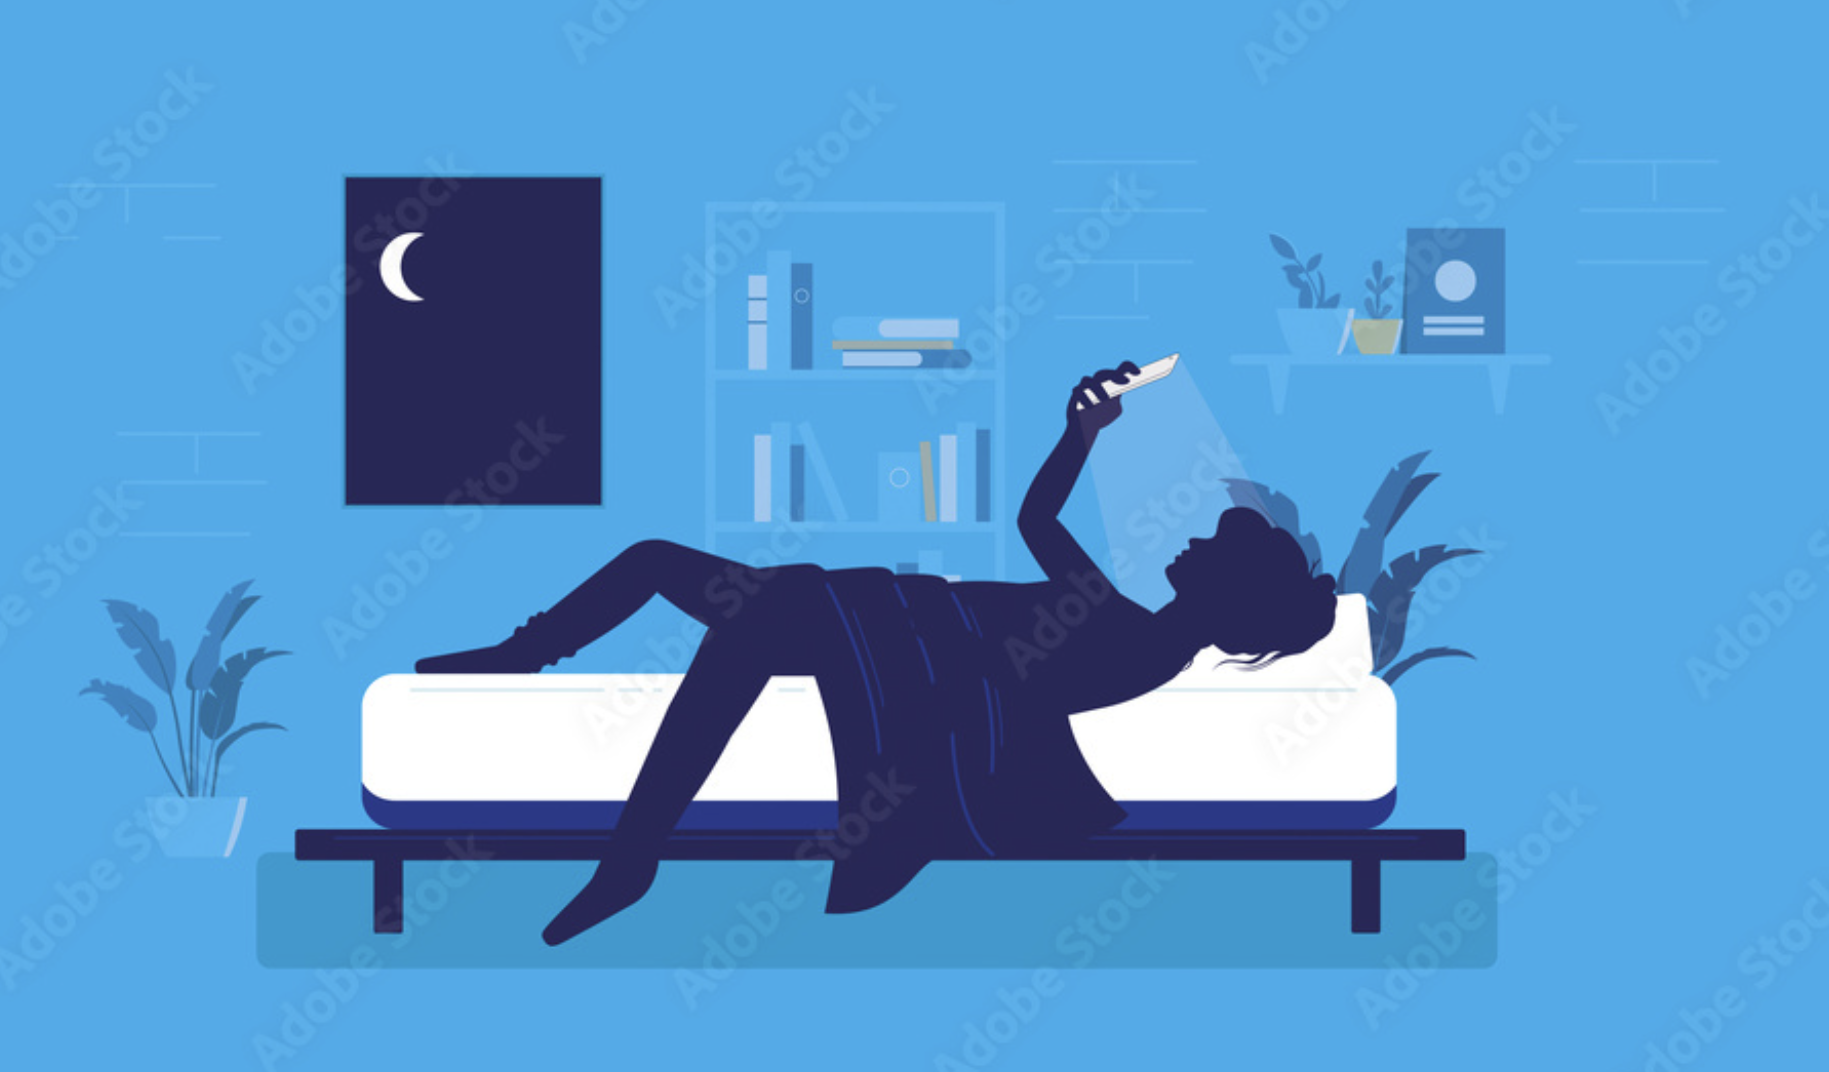

Ruth Pikovsky 318284718 & Olga Noga Shalit 321049090

#Causal Question:
### Is there a causal relationship between excessive social media consumption and reduced sleep quality?


##### **Dataset name**:
SocialMediaUsage_SleepData_SG
##### **Link**:
https://www.kaggle.com/datasets/globalmediadata/socialmediausage-sleepdata-sg/data


#Treatment:
Average Daily Social Media Use Time (minutes), divided to high (1) if above average, low (0) if below average.

#Outcome:
Sleep quality.
Will be derived from a weighted combination of the following parameters:
●  	Sleep Efficiency (%)
●  	Sleep Quality Rating
●  	Total Sleep Time (hours)
●  	Wake After Sleep Onset (WASO) (minutes)
●  	Number of Awakenings (during sleep)

The weighting scheme is used to bring the parameters to the same order of magnitude, the final outcome is a number between 0 and 1. We give positive weights to the first three parameters and negative weights to the last two, since good sleep quality requires the first three to be high and the last two to be low. Also, we would examine each of them separately.

#Observed Covariates:
everything else.

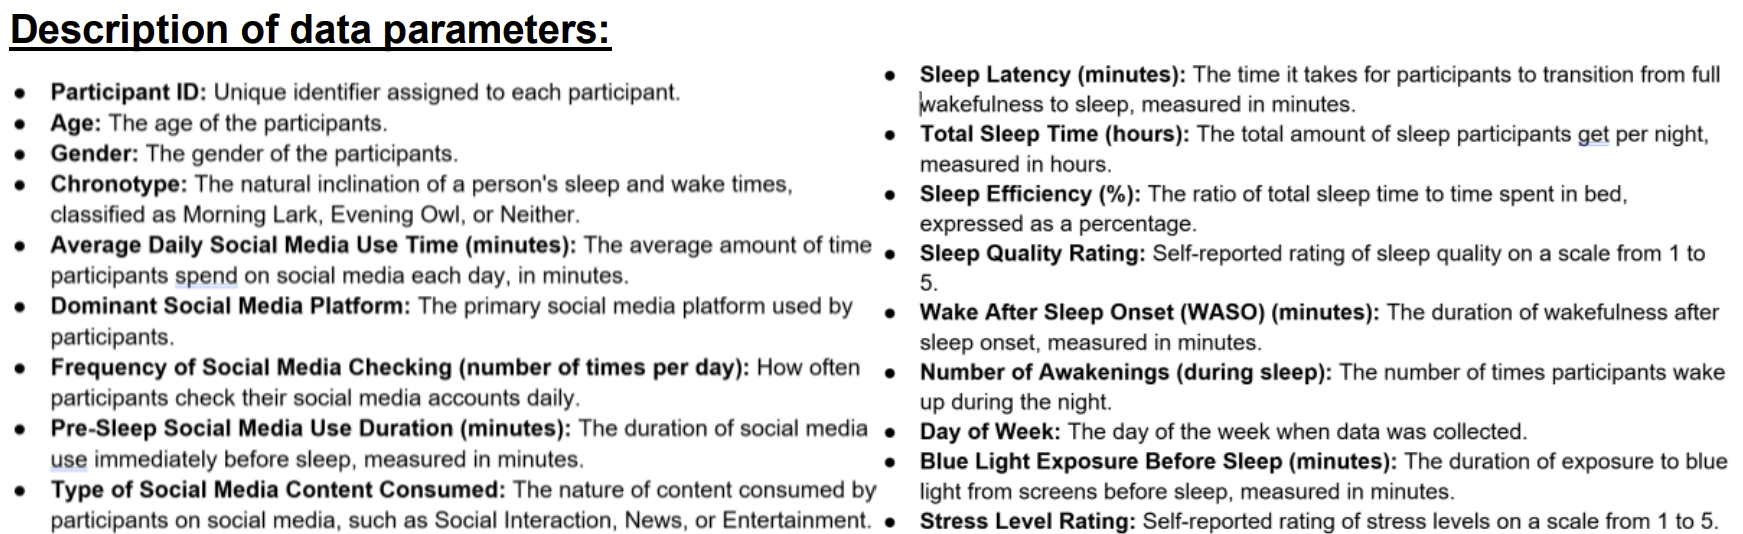

# Data Preperation:

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


def preprocess_covariates(df, y, t):
    drop_columns =  [t] + y
    df = df.drop(columns=drop_columns)
    X = pd.get_dummies(df, drop_first=True) # Perform one-hot encoding on categorical variables
    X.index = df.index
    return X

def define_T(df, t):
  average = df[t].mean()
  df['T'] = df[t].apply(lambda x: 1 if x > average else 0) # Create a new column 'T' where 1 indicates value > average, else 0
  return df['T']

def define_Y(df, y, weights):
    Y = 0
    for y_i, weight in zip(y, weights):
        normalized = (df[y_i] - df[y_i].min()) / (df[y_i].max() - df[y_i].min())
        Y += weight * normalized
    df['Y'] = Y
    return Y

def calc_propensity(df, X):
    t = df["T"]
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('logistic_classifier', LogisticRegression(max_iter=1000))
    ])
    pipe.fit(X, t)
    threshold = 0.5
    df['propensity_lin'] = pipe.predict_proba(X)[:, 1]
    propensity = df['propensity_lin']
    return propensity

def calc_propensity_gbm(df, X):
    t = df["T"]
    gbm_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
    gbm_model.fit(X, t)
    df['propensity_gbm'] = gbm_model.predict_proba(X)[:, 1]
    return df['propensity_gbm']

def calc_propensity_rf(df, X):
    t = df["T"]
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X, t)
    df['propensity_rf'] = rf_model.predict_proba(X)[:, 1]
    return df['propensity_rf']

df = pd.read_csv('SocialMediaUsage_SleepLatencyAnalysis_Singapore.csv')
df = df.drop(columns=['Participant ID', 'Cortisol Level (pg/mL)', 'Melatonin Level (pg/mL)'])
t = 'Average Daily Social Media Use Time (minutes)'
y = ['Sleep Efficiency (%)', 'Sleep Quality Rating', 'Total Sleep Time (hours)', 'Wake After Sleep Onset (WASO) (minutes)', 'Number of Awakenings (during sleep)']
X = preprocess_covariates(df, y, t)
X.head()

T = define_T(df, t)
weights = [0, 1, 0, -0, -0]
Y = define_Y(df, y, weights)
propensity= calc_propensity(df, X)
propensity_rf = calc_propensity_rf(df, X)
propensity_gbm = calc_propensity_gbm(df, X)

predictions={}
df.head()

Age  Gender   Chronotype  Average Daily Social Media Use Time (minutes)  \
0   56   Other  Evening Owl                                     123.661212   
1   46  Female      Neither                                      68.877915   
2   32    Male      Neither                                     143.799199   
3   60   Other  Evening Owl                                     213.318626   
4   25  Female  Evening Owl                                     183.767226   

  Dominant Social Media Platform  \
0                      Instagram   
1                      Instagram   
2                         TikTok   
3                        Twitter   
4                        Twitter   

   Frequency of Social Media Checking (number of times per day)  \
0                                                 20              
1                                                 40              
2                                                 29              
3                                                  5              
4                                                 39              

   Pre-Sleep Social Media Use Duration (minutes)  \
0                                      72.650150   
1                                      40.096685   
2                                      58.147004   
3                                      51.842214   
4                                      81.919265   

  Type of Social Media Content Consumed  Sleep Latency (minutes)  \
0                    Social Interaction                20.961023   
1                                  News                19.012622   
2                                  News                20.481638   
3                    Social Interaction                29.892398   
4                         Entertainment                28.905470   

   Total Sleep Time (hours)  ...  Wake After Sleep Onset (WASO) (minutes)  \
0                  4.953115  ...                                28.454612   
1                  6.466231  ...                                18.160790   
2                  5.204305  ...                                29.832344   
3                  3.760281  ...                                37.331240   
4                  5.186388  ...                                22.922240   

   Number of Awakenings (during sleep)  Day of Week  \
0                                    3       Friday   
1                                    2       Friday   
2                                    3       Friday   
3                                    5     Thursday   
4                                    4     Thursday   

   Blue Light Exposure Before Sleep (minutes) Stress Level Rating  T  \
0                                   47.683296            3.802238  0   
1                                   22.171777            2.768907  0   
2                                   29.615623            4.704535  1   
3                                   46.778311            5.000000  1   
4                                   46.607758            5.000000  1   

          Y  propensity_lin  propensity_rf  propensity_gbm  
0  0.592266        0.346995           0.28        0.108442  
1  0.886098        0.013064           0.00        0.003806  
2  0.126594        0.815098           0.90        0.956461  
3  0.000000        0.965993           0.97        0.971167  
4  0.046624        0.996007           0.98        0.996812  

[5 rows x 22 columns]

We want to check if we have overlap:

propensity_lin


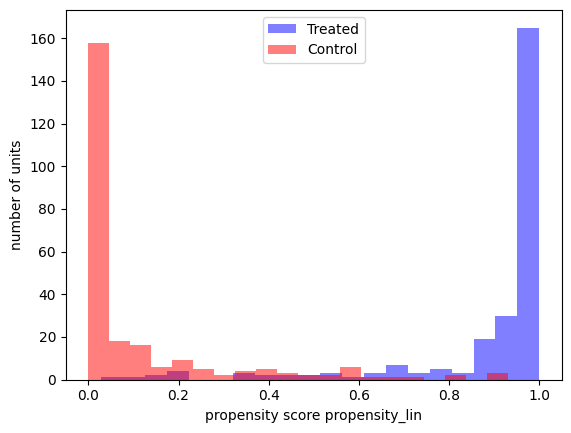

propensity_rf


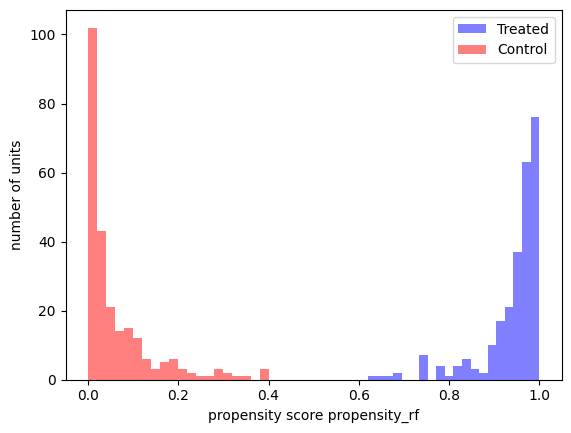

propensity_gbm


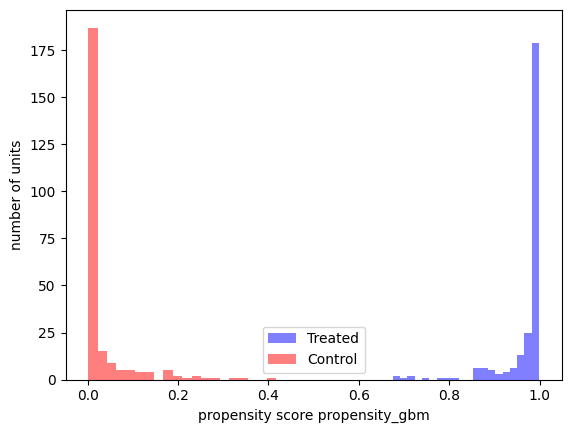

In [2]:
def propensity_histogram(df, model):
    treated = df[df['T'] == 1]
    control = df[df['T'] == 0]
    model_name = "propensity" + "_" + model
    print(model_name)
    treat_plt = plt.hist(treated[model_name], fc=(0, 0, 1, 0.5), bins=20, label='Treated')
    cont_plt = plt.hist(control[model_name], fc=(1, 0, 0, 0.5), bins=20, label='Control')
    plt.legend()
    plt.xlabel('propensity score'+ " " + model_name)
    plt.ylabel('number of units')
    plt.show()

propensity_histogram(df, "lin")
propensity_histogram(df, "rf")
propensity_histogram(df,"gbm")

We didn't have a perfect overlap using any of the methods, but we had the best overlap out of three using logistic regression. In order to improve common support overlap we used common support trimming. The resulting histogram is:


propensity_lin


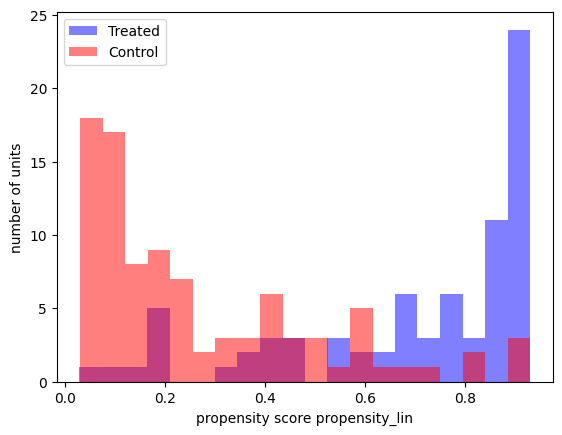

Number of treated samples before trimming: 256
Number of control samples before trimming: 244
Number of treated samples after trimming: 77
Number of control samples after trimming: 93


In [3]:
# Trim the data and recalculate covariate matrix X
def trim_non_overlap(df):
    min_treated = df[df['T'] == 1]['propensity_lin'].min()
    max_control = df[df['T'] == 0]['propensity_lin'].max()
    df_trimmed = df[(df['propensity_lin'] >= min_treated) & (df['propensity_lin'] <= max_control)]
    return df_trimmed

df_trimmed = trim_non_overlap(df)
X_trimmed = X.loc[df_trimmed.index]

# Plot the updated propensity score histograms after trimming
propensity_histogram(df_trimmed, "lin")
num_treated = df[df['T'] == 1].shape[0]
num_control = df[df['T'] == 0].shape[0]
print("Number of treated samples before trimming:", num_treated)
print("Number of control samples before trimming:", num_control)

num_treated = df_trimmed[df_trimmed['T'] == 1].shape[0]
num_control = df_trimmed[df_trimmed['T'] == 0].shape[0]
print("Number of treated samples after trimming:", num_treated)
print("Number of control samples after trimming:", num_control)

## Expected Outcomes
We would expect that there is a causal relationship between the treatment and the outcome. However,
there are conflicting studies on the subject. Therefore, it would be interesting to prove or disprove them,
using our dataset.


## Possible Challenges
Assumptions:
1. SUTVA terms are met.
2. Confounders:
We assume that most of the important confounders exist in the data (such as age, chronotype
etc). Some confounders that might exist that are not in the data are the sleep conditions (if the
participant is sleeping alone, in a quiet or noisy environment etc). We assume that we have
enough participants so that this confounder will be averaged out. Also, since the participants are
using social media and living in Singapore which has one of the lowest homelessness and
poverty rates in the world, we assume they are in the middle class and above so that their sleep
conditions are adequate.


# Scope and Methods:

Average Treatment Effect inference using the methods we learned
* Covariate adjustment
* S-learner
* T-learner
* Matching accorrding to propensity
* Matching accorrding to covariates
* IPW
* Doubly Robust

Covariate adjustment

In [4]:
def covariate_adjustment(df, X, predictions):
    """
    Covariate adjustment using a linear regression model to estimate ATE.
    """
    y = df['Y']
    t = df['T']

    X_with_T = np.concatenate([X, t.values.reshape(-1, 1)], axis=1)
    cov_adj_model = LinearRegression().fit(X_with_T, y)
    X_with_T_treated = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
    X_with_T_control = np.concatenate([X, np.zeros((X.shape[0], 1))], axis=1)

    # Predicted outcomes
    y1_pred = cov_adj_model.predict(X_with_T_treated)  # Treated outcomes
    y0_pred = cov_adj_model.predict(X_with_T_control)  # Control outcomes

    # ATE calculation
    ate_cov_adj = np.mean(y1_pred - y0_pred)

    # Store predictions for treated and control
    predictions['y1_pred_cov_adj'] = y1_pred
    predictions['y0_pred_cov_adj'] = y0_pred

    return ate_cov_adj, y1_pred, y0_pred




S-learner



In [5]:
def S_learner(df, X, predictions):
    """
    S-Learner function to estimate ATE by training a model on covariates and treatment.
    """
    X_with_T = np.concatenate([X, df[['T']]], axis=1)
    y = df['Y']

    # Train a single model on X and T
    s_model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_with_T, y)

    X_with_T_treated = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
    X_with_T_control = np.concatenate([X, np.zeros((X.shape[0], 1))], axis=1)

    # Predicted outcomes for treated and control
    y1_pred = s_model.predict(X_with_T_treated)
    y0_pred = s_model.predict(X_with_T_control)

    # ATE calculation
    ate_s = np.mean(y1_pred - y0_pred)

    # Store the predicted outcomes for treated and control
    predictions['y1_pred_slearner'] = y1_pred
    predictions['y0_pred_slearner'] = y0_pred

    return ate_s, y1_pred, y0_pred

 T-learner

In [6]:
def T_learner(df, X, predictions):
    """
    T-Learner to estimate ATE by training separate models for treated and control groups,
    and then predicting outcomes for all individuals.
    """
    y = df['Y']
    t = df['T']
    X = X.reindex(df.index)

    # Train two separate models: one for the treated group and one for the control group
    model_treated = RandomForestRegressor(n_estimators=100, random_state=42).fit(X[df['T'] == 1], y[df['T'] == 1])
    model_control = RandomForestRegressor(n_estimators=100, random_state=42).fit(X[df['T'] == 0], y[df['T'] == 0])

    # Predict outcomes for treated (T=1) and control (T=0) for all individuals
    y1_pred = model_treated.predict(X)
    y0_pred = model_control.predict(X)

    # ATE calculation
    ate_t_learner = np.mean(y1_pred - y0_pred)

    # Store the predicted outcomes for treated and control
    predictions['y1_pred_tlearner'] = y1_pred
    predictions['y0_pred_tlearner'] = y0_pred

    return ate_t_learner, y1_pred, y0_pred


Matching accorrding to propensity

In [7]:
def propensity_score_matching(df, predictions):
    """
    Perform nearest neighbor matching based on propensity scores (1-NN) and calculate ATE.
    """
    treated = df[df['T'] == 1]
    control = df[df['T'] == 0]

    # Use propensity scores for matching
    treated_ps = treated[['propensity_lin']]
    control_ps = control[['propensity_lin']]

    # Perform nearest neighbor matching (1 nearest neighbor)
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(control_ps)

    # Find nearest neighbors for treated individuals
    distances, indices = neigh.kneighbors(treated_ps)

    # Get matched control individuals
    matched_control = control.iloc[indices.flatten()]

    # Calculate CATE
    cate = treated['Y'].values - matched_control['Y'].values

    # ATE calculation
    ate_matching_prop = np.mean(cate)

    # Store the predicted outcomes for treated and control
    predictions['y1_pred_matching_prop'] = treated['Y']
    predictions['y0_pred_matching_prop'] = matched_control['Y']

    return ate_matching_prop, treated['Y'], matched_control['Y']

Matching accorrding to covariates

In [8]:
def covariate_matching(df, X, predictions):
    """
    Perform nearest neighbor matching based on covariates (1-NN) and calculate ATE.
    """
    X = X.reindex(df.index)
    treated = df[df['T'] == 1]
    control = df[df['T'] == 0]
    treated_X = X[df['T'] == 1]
    control_X = X[df['T'] == 0]

    # Perform nearest neighbor matching (1 nearest neighbor)
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(control_X)

    # Find nearest neighbors for treated individuals
    distances, indices = neigh.kneighbors(treated_X)

    # Get matched control individuals
    matched_control = control.iloc[indices.flatten()]

    # Calculate CATE
    cate = treated['Y'].values - matched_control['Y'].values

    # ATE calculation
    ate_matching_cov = np.mean(cate)

    # Store the predicted outcomes for treated and control
    predictions['y1_pred_matching_cov'] = treated['Y']
    predictions['y0_pred_matching_cov'] = matched_control['Y']

    return ate_matching_cov, treated['Y'], matched_control['Y']

IPW

In [9]:
def IPW(df, predictions):
    """
    Perform ATE calculation using IPW.
    """
    # Calculate weights
    treated_weight = 1 / df['propensity_lin']
    control_weight = 1 / (1 - df['propensity_lin'])

    # Treated group outcome weighted
    y1_ipw = treated_weight * df['Y'] * df['T']
    treated_outcome = np.sum(y1_ipw)

    # Control group outcome weighted
    y0_ipw = control_weight * df['Y'] * (1 - df['T'])
    control_outcome = np.sum(y0_ipw)

    # ATE calculation
    ate_ipw = (1/len(df))*(treated_outcome - control_outcome)

    # Store the predicted outcomes for treated and control
    predictions['y1_ipw'] = y1_ipw
    predictions['y0_ipw'] = y0_ipw

    return ate_ipw, y1_ipw, y0_ipw

Doubly robust

In [10]:
def doubly_robust(df, X, predictions):
    """
    Perform ATE calculation using Doubly Robust.
    """
    X = X.reindex(df.index)
    y = df['Y']
    model_treated = RandomForestRegressor(n_estimators=100, random_state=42).fit(X[df['T'] == 1], y[df['T'] == 1])
    model_control = RandomForestRegressor(n_estimators=100, random_state=42).fit(X[df['T'] == 0], y[df['T'] == 0])

    # Predict outcomes for all individuals as if treated and as if control
    df = df.copy()
    df.loc[:, 'y1_pred_dr'] = model_treated.predict(X)
    df.loc[:, 'y0_pred_dr'] = model_control.predict(X)
    y1_dr = df['y1_pred_dr']
    y0_dr = df['y0_pred_dr']
    treated = df[df['T'] == 1]
    control = df[df['T'] == 0]

    # Doubly Robust Estimator for ATE
    g1_hat = treated['y1_pred_dr'] + (treated['T'] / treated['propensity_lin']) * (treated['Y'] - treated['y1_pred_dr'])
    g0_hat = control['y0_pred_dr'] + ((1 - control['T']) / (1 - control['propensity_lin'])) * (control['Y'] - control['y0_pred_dr'])

    # ATE calculation
    ate_dr = np.mean(g1_hat) - np.mean(g0_hat)

    # Store the predicted outcomes for treated and control
    predictions['y1_pred_dr'] = df['y1_pred_dr']
    predictions['y0_pred_dr'] = df['y0_pred_dr']
    return ate_dr, y1_dr, y0_dr

# Plotting tools and calculations:

In [11]:
def plot_matches(df, X, matched_control, treated):
    """
    Plot distributions of covariates before and after matching.
    Includes the `propensity_lin` plot for distribution comparison.
    """
    matched_control_df = X.loc[matched_control.index].copy()
    treated_df = X.loc[treated.index].copy()

    for var in X.columns:
        C_COLOUR = 'grey'
        T_COLOUR = 'green'
        C_LABEL = 'Control'
        T_LABEL = 'Treatment'

        # Create subplots
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))

        # Plotting for binary or continuous variable
        if len(X[var].unique()) == 2:  # Binary variable
            sns.histplot(X[X.index.isin(treated.index)][var], bins=2, color=T_COLOUR, label=T_LABEL, ax=ax[0], stat="density")
            sns.histplot(X[X.index.isin(matched_control.index)][var], bins=2, color=C_COLOUR, label=C_LABEL, ax=ax[0], stat="density")
            ax[0].set_title(f'{var} Before matching', fontsize=12)

            sns.histplot(treated_df[var], bins=2, color=T_COLOUR, label=T_LABEL, ax=ax[1], stat="density")
            sns.histplot(matched_control_df[var], bins=2, color=C_COLOUR, label=C_LABEL, ax=ax[1], stat="density")
            ax[1].set_title(f'{var} After matching', fontsize=12)

        else:  # Continuous variable
            sns.kdeplot(data=X[X.index.isin(treated.index)], x=var, fill=True, color=T_COLOUR, label=T_LABEL, ax=ax[0])
            sns.kdeplot(data=X[X.index.isin(matched_control.index)], x=var, fill=True, color=C_COLOUR, label=C_LABEL, ax=ax[0])
            ax[0].set_title(f'{var} Before matching', fontsize=12)

            sns.kdeplot(data=treated_df, x=var, fill=True, color=T_COLOUR, label=T_LABEL, ax=ax[1])
            sns.kdeplot(data=matched_control_df, x=var, fill=True, color=C_COLOUR, label=C_LABEL, ax=ax[1])
            ax[1].set_title(f'{var} After matching', fontsize=12)

        ax[1].set_ylabel("")
        plt.tight_layout()  # Automatically adjust spacing

        # Add legend
        ax[0].legend(loc='upper left')

        # Adjust spacing if needed
        plt.subplots_adjust(top=0.9, wspace=0.3)

    # Plot propensity_lin distribution
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    sns.kdeplot(data=df[df['T'] == 1], x='propensity_lin', fill=True, color=T_COLOUR, label=T_LABEL, ax=ax[0])
    sns.kdeplot(data=df[df['T'] == 0], x='propensity_lin', fill=True, color=C_COLOUR, label=C_LABEL, ax=ax[0])
    ax[0].set_title('propensity_lin Before matching', fontsize=12)

    sns.kdeplot(data=df.loc[treated.index], x='propensity_lin', fill=True, color=T_COLOUR, label=T_LABEL, ax=ax[1])
    sns.kdeplot(data=df.loc[matched_control.index], x='propensity_lin', fill=True, color=C_COLOUR, label=C_LABEL, ax=ax[1])
    ax[1].set_title('propensity_lin After matching', fontsize=12)

    ax[1].set_ylabel("")
    plt.tight_layout()  # Automatically adjust spacing
    ax[0].legend(loc='upper left')

    # Display the plots
    plt.show()

def plot_actual_vs_predicted(y_true, y_pred, title):
    """
    Plot the actual vs. predicted outcomes
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Actual Outcomes')
    plt.ylabel('Predicted Outcomes')
    plt.title(title)
    plt.show()

def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE) between actual values and predictions.
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse


def bootstrap_CI(df, predictions, n_bootstrap=50, ci=95, method="IPW", X_trimmed=None):
    """
    Calculate ATE with confidence interval, using bootstrap.
    """
    bootstrap_ate = []

    for _ in range(n_bootstrap):
        # Sample with replacement from the data
        df_resampled = df.sample(n=len(df), replace=True)

        # Recalculate ATE using the resampled data
        if method == "IPW":
          ate_resampled , _ , _  = IPW(df_resampled, predictions)
        elif method == "S_learner":
          ate_resampled ,_ , _ = S_learner(df_resampled, X_trimmed, predictions)
        elif method == "T_learner":
          ate_resampled,_ , _ = T_learner(df_resampled, X_trimmed, predictions)
        elif method == "Matching_prop":
          ate_resampled,_ , _= propensity_score_matching(df_resampled, predictions)
        elif method == "Matching_cov":
          ate_resampled,_ , _= covariate_matching(df_resampled, X_trimmed, predictions)
        elif method == "Covariate_Adjustment":
          ate_resampled,_ , _ = covariate_adjustment(df_resampled, X_trimmed, predictions)
        elif method == "Doubly Robust":
          ate_resampled,_ , _ = doubly_robust(df_resampled, X_trimmed, predictions)
        bootstrap_ate.append(ate_resampled)
    bootstrap_ate = np.array(bootstrap_ate)

    # Calculate the percentiles for the confidence interval
    lower_bound = np.percentile(bootstrap_ate, (100 - ci) / 2)
    upper_bound = np.percentile(bootstrap_ate, 100 - (100 - ci) / 2)
    return lower_bound, upper_bound, bootstrap_ate


def plot_bootstrap_distribution(bootstrap_ate, ci_lower, ci_upper, ci=95):
    """
    Plot the bootstrap distribution of ATE estimates with confidence interval.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(bootstrap_ate, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(ci_lower, color='red', linestyle='--', label=f'{ci}% CI Lower Bound')
    plt.axvline(ci_upper, color='green', linestyle='--', label=f'{ci}% CI Upper Bound')
    plt.xlabel("ATE Estimate")
    plt.ylabel("Frequency")
    plt.title(f"Bootstrap Distribution of ATE Estimates ({ci}% Confidence Interval)")
    plt.legend()
    plt.show()

# Results:

<-------------------IPW--------------------------->
ATE using IPW: -0.22008867435417948
95% Confidence Interval for ATE using bootstrap: [-0.3783938123882696, -0.003685942971642376]


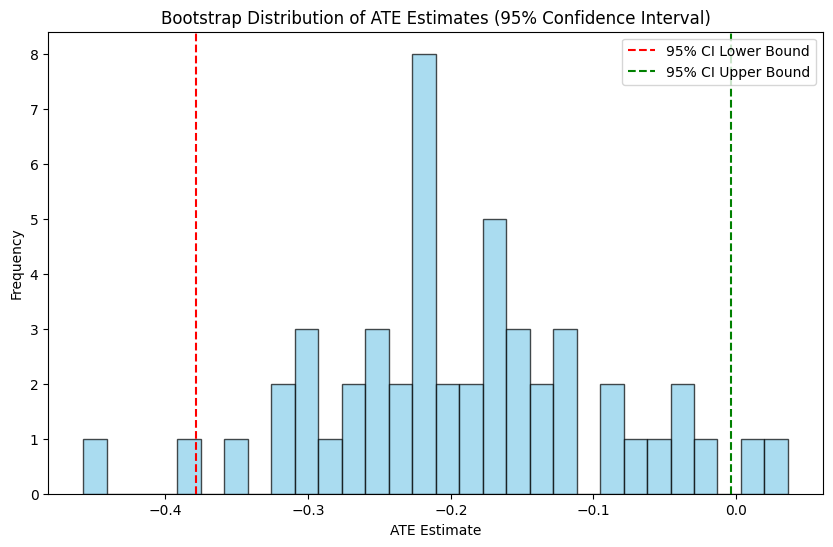

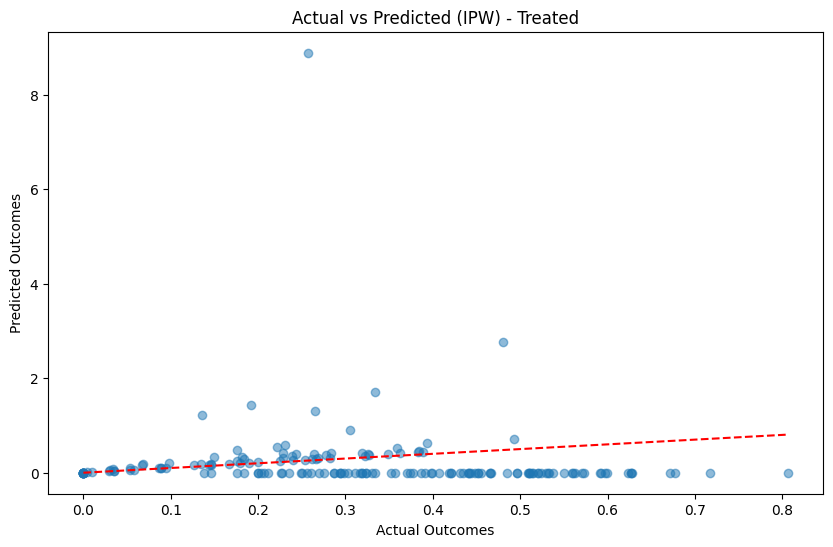

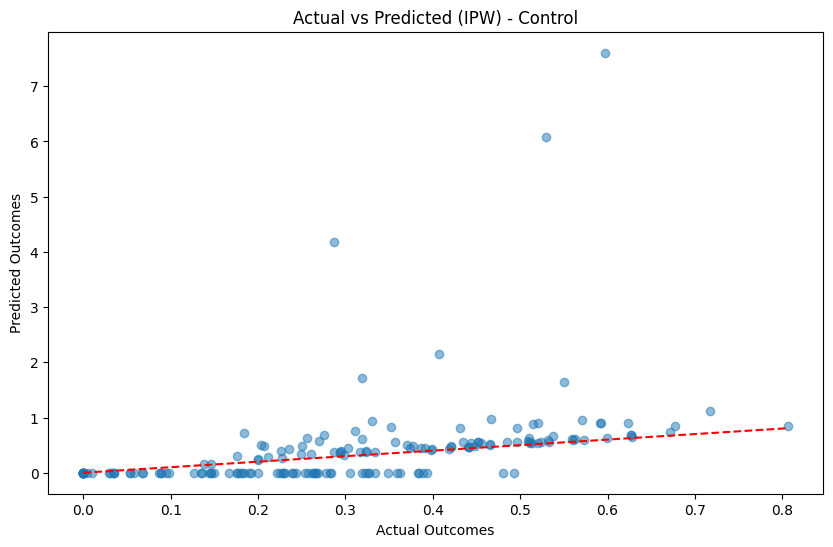

The Treated RMSE is: 0.7845
The Control RMSE is: 0.7994
<----------------------S-Learner------------------------>
ATE using S-Learner: -0.21203526428072436
95% Confidence Interval for ATE using bootstrap: [-0.27510998510245127, -0.20227884114333183]


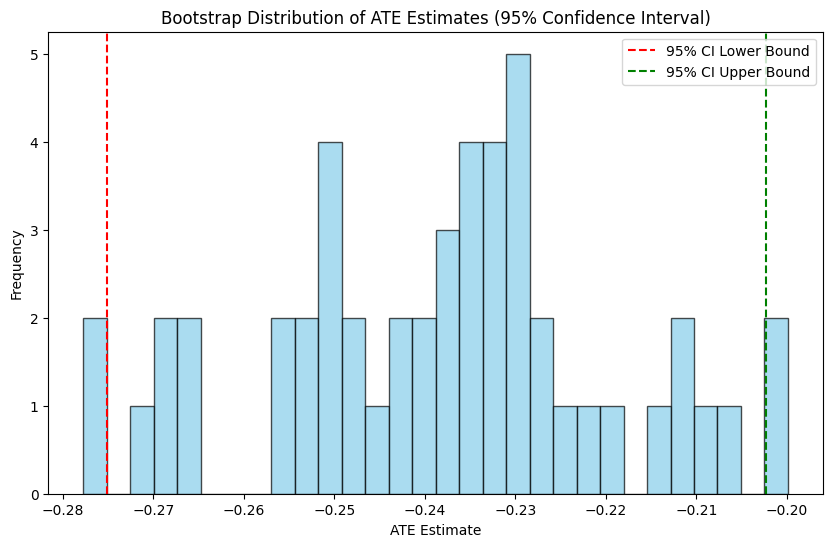

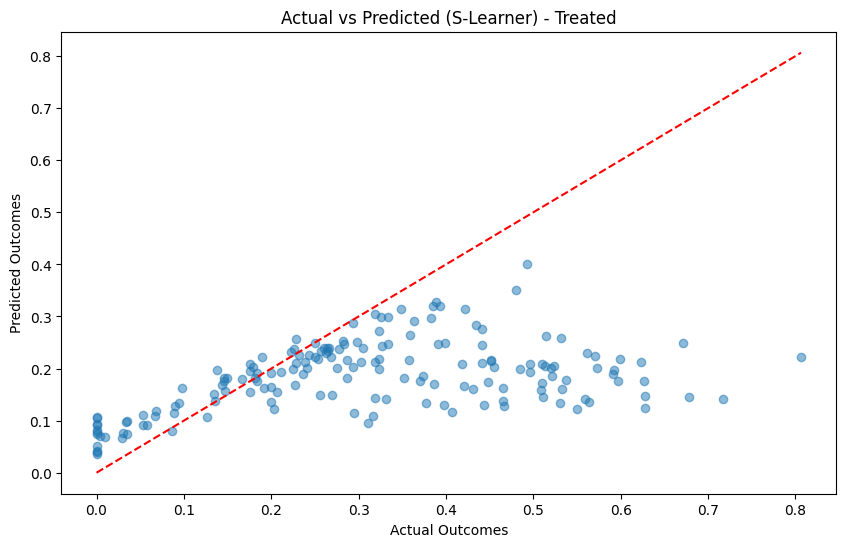

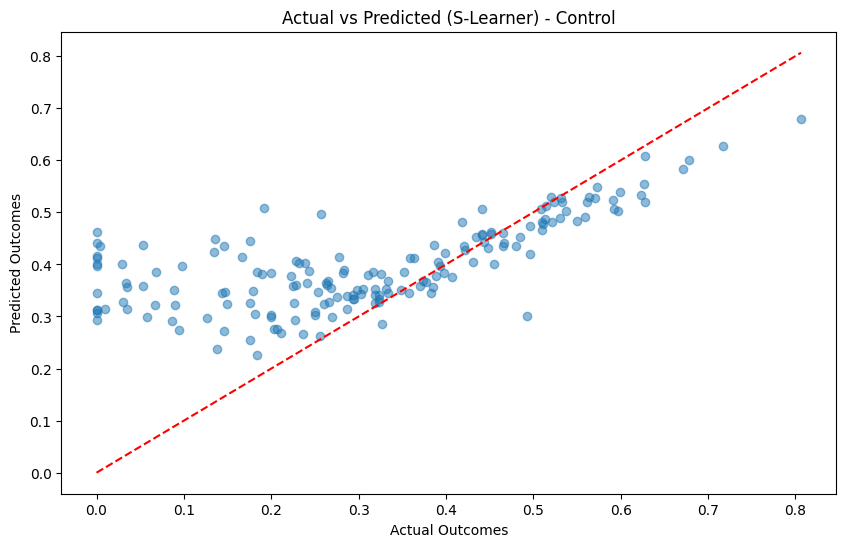

The Treated RMSE is: 0.2055
The Control RMSE is: 0.1641
<----------------------T-Learner------------------------>
ATE using T-Learner: -0.21061006424253204
95% Confidence Interval for ATE using bootstrap: [-0.2716857106983316, -0.18439702811698414]


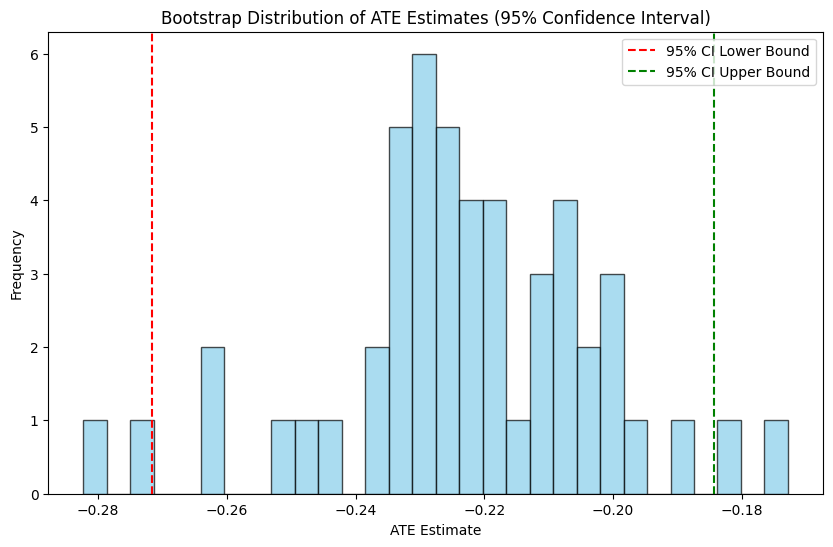

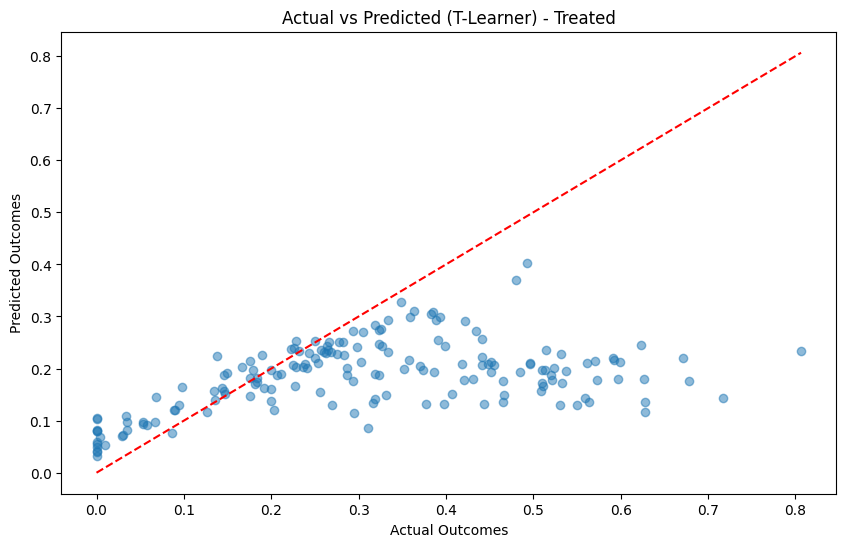

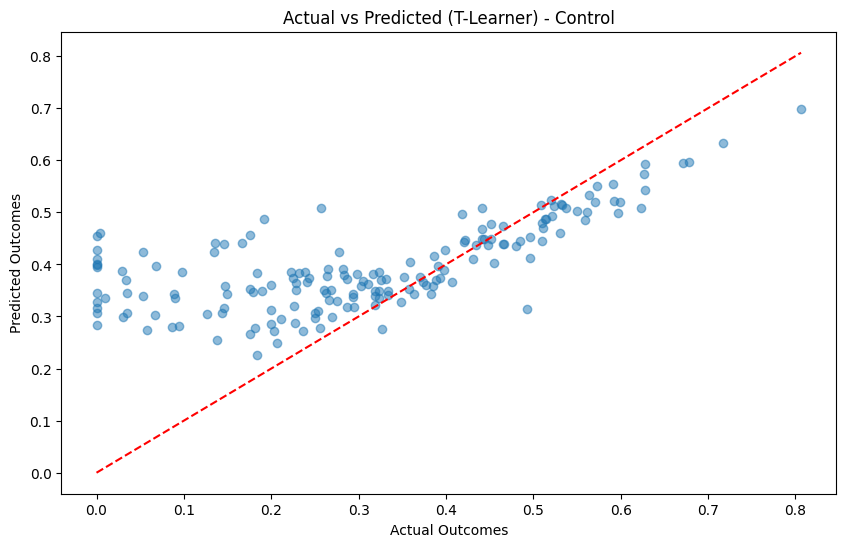

The Treated RMSE is: 0.2043
The Control RMSE is: 0.1629
<----------------------Covariate Adjustment------------------------>
ATE using Covariate Adjustment: -0.1902193562704954
95% Confidence Interval for ATE using bootstrap: [-0.2792901473939476, -0.2098268168683173]


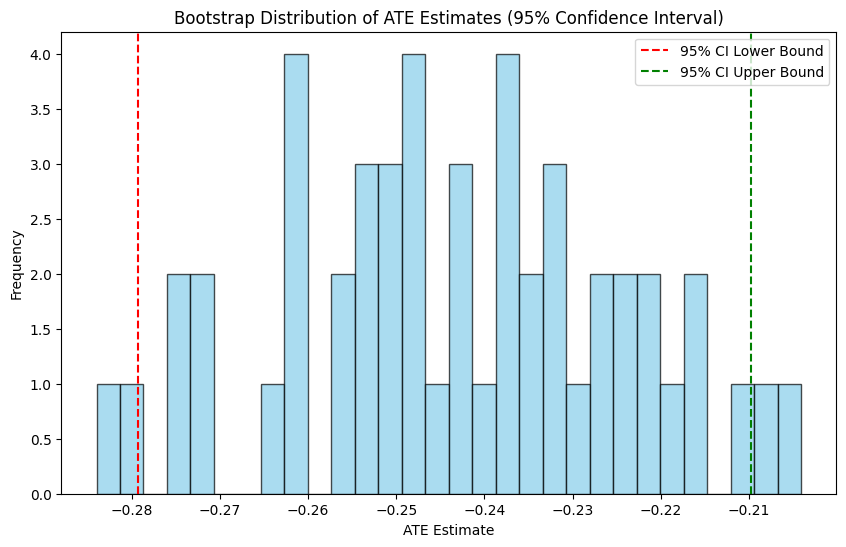

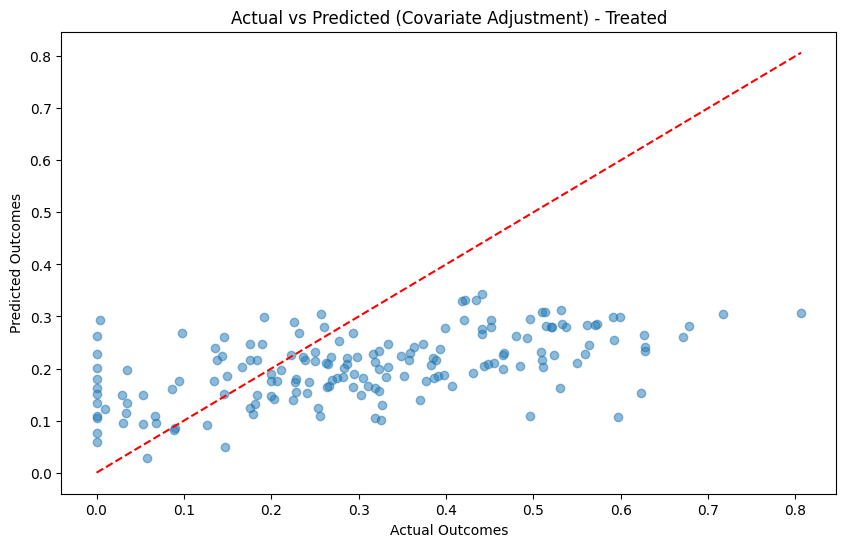

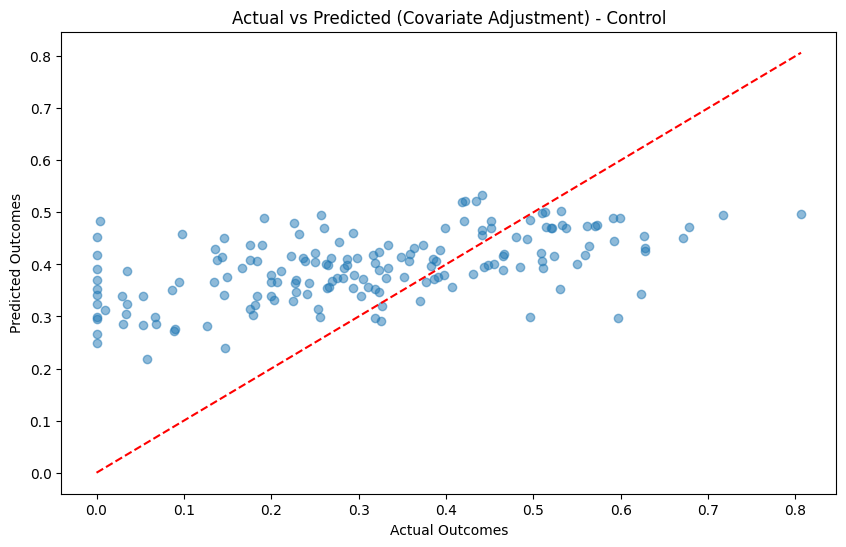

The Treated RMSE is: 0.1878
The Control RMSE is: 0.1785
<----------------------Doubly Robust------------------------>
ATE using Doubly Robust estimators: -0.24177956771231277
95% Confidence Interval for ATE using bootstrap: [-0.2764391601764719, -0.1974478298998085]


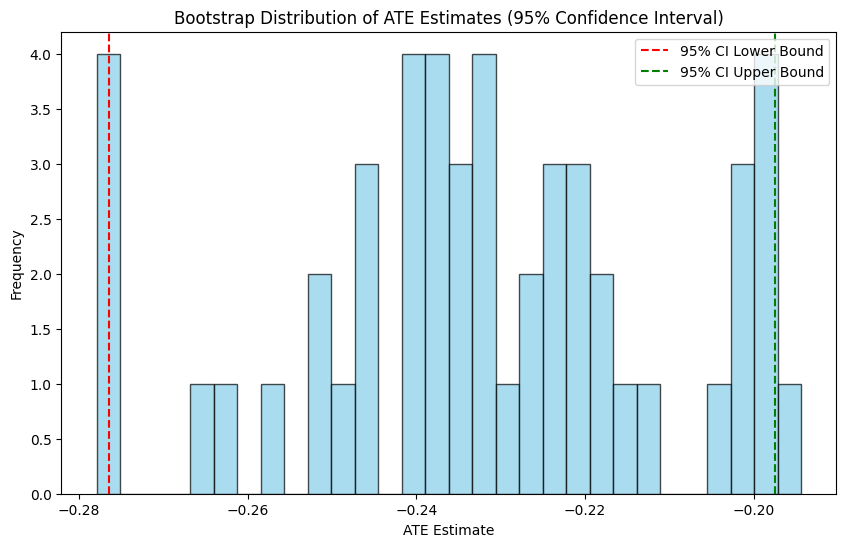

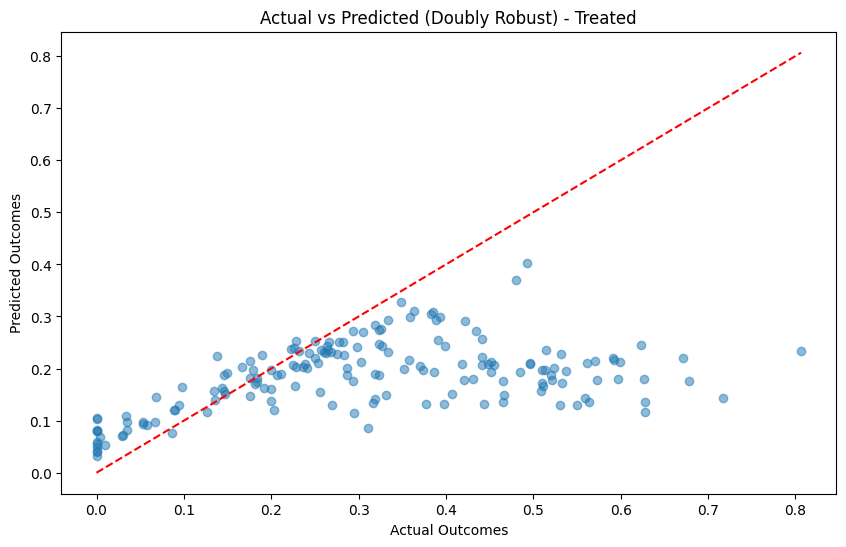

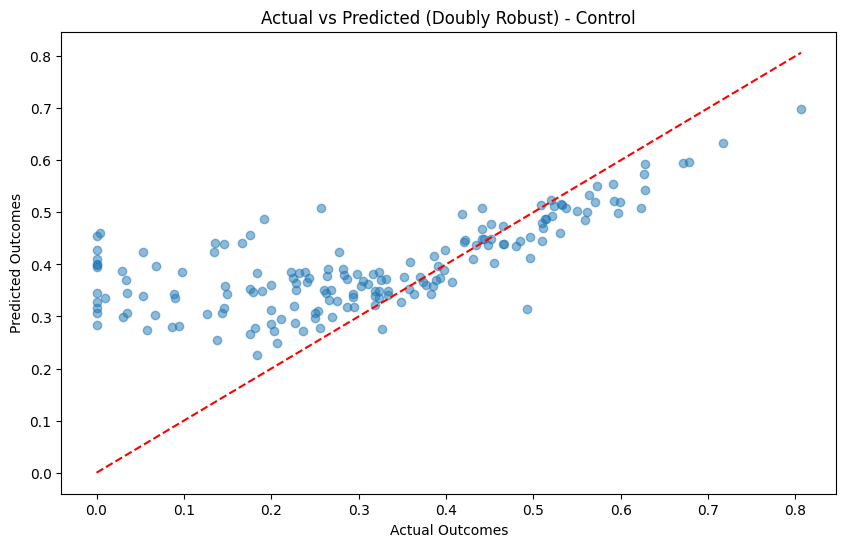

The Treated RMSE is: 0.2043
The Control RMSE is: 0.1629


In [12]:
print("<-------------------IPW--------------------------->")

# Calculate IPW
ate_ipw, treated_pred_ipw, control_pred_ipw = IPW(df_trimmed, predictions)
print(f"ATE using IPW: {ate_ipw}")

# Calculate bootstrap confidence intervals
ci_lower, ci_upper, bootstrap_ate_distribution = bootstrap_CI(df_trimmed, predictions, method="IPW")
print(f"{95}% Confidence Interval for ATE using bootstrap: [{ci_lower}, {ci_upper}]")
plot_bootstrap_distribution(bootstrap_ate_distribution, ci_lower, ci_upper, ci=95)

# Plot for IPW
plot_actual_vs_predicted(df_trimmed['Y'], treated_pred_ipw, "Actual vs Predicted (IPW) - Treated")
plot_actual_vs_predicted(df_trimmed['Y'], control_pred_ipw, "Actual vs Predicted (IPW) - Control")

# Calculate RMSE for treated and control predictions
rmse_treated_ipw = calculate_rmse(df_trimmed['Y'], treated_pred_ipw)
rmse_control_ipw = calculate_rmse(df_trimmed['Y'], control_pred_ipw)

# Print the results with formatting
print(f"The Treated RMSE is: {rmse_treated_ipw:.4f}")
print(f"The Control RMSE is: {rmse_control_ipw:.4f}")


print("<----------------------S-Learner------------------------>")

# Calculate S-Learner
ate_s, treated_pred_s, control_pred_s = S_learner(df_trimmed, X_trimmed, predictions)
print(f"ATE using S-Learner: {ate_s}")

# Calculate bootstrap confidence intervals
ci_lower, ci_upper, bootstrap_ate_distribution = bootstrap_CI(df_trimmed, predictions, method="S_learner", X_trimmed=X_trimmed)
print(f"{95}% Confidence Interval for ATE using bootstrap: [{ci_lower}, {ci_upper}]")
plot_bootstrap_distribution(bootstrap_ate_distribution, ci_lower, ci_upper, ci=95)

# Plot for S-Learner
plot_actual_vs_predicted(df_trimmed['Y'], treated_pred_s , "Actual vs Predicted (S-Learner) - Treated")
plot_actual_vs_predicted(df_trimmed['Y'], control_pred_s , "Actual vs Predicted (S-Learner) - Control")

# Calculate RMSE for treated and control predictions
rmse_treated_s = calculate_rmse(df_trimmed['Y'], treated_pred_s)
rmse_control_s = calculate_rmse(df_trimmed['Y'], control_pred_s)

# Print the results with formatting
print(f"The Treated RMSE is: {rmse_treated_s:.4f}")
print(f"The Control RMSE is: {rmse_control_s:.4f}")

print("<----------------------T-Learner------------------------>")


# Calculate T-Learner
ate_t, treated_pred_t, control_pred_t = T_learner(df_trimmed, X_trimmed, predictions)
print(f"ATE using T-Learner: {ate_t}")

# Calculate bootstrap confidence intervals
ci_lower, ci_upper, bootstrap_ate_distribution = bootstrap_CI(df_trimmed, predictions=predictions, method="T_learner", X_trimmed=X_trimmed)
print(f"{95}% Confidence Interval for ATE using bootstrap: [{ci_lower}, {ci_upper}]")
plot_bootstrap_distribution(bootstrap_ate_distribution, ci_lower, ci_upper, ci=95)

# Plot for T-Learner
plot_actual_vs_predicted(df_trimmed['Y'], treated_pred_t , "Actual vs Predicted (T-Learner) - Treated")
plot_actual_vs_predicted(df_trimmed['Y'], control_pred_t, "Actual vs Predicted (T-Learner) - Control")

# Calculate RMSE for treated and control predictions
rmse_treated_t = calculate_rmse(df_trimmed['Y'], treated_pred_t)
rmse_control_t = calculate_rmse(df_trimmed['Y'], control_pred_t)

# Print the results with formatting
print(f"The Treated RMSE is: {rmse_treated_t:.4f}")
print(f"The Control RMSE is: {rmse_control_t:.4f}")


print("<----------------------Covariate Adjustment------------------------>")


# Apply covariate adjustment
ate_cov_adj, treated_pred, control_pred = covariate_adjustment(df_trimmed, X_trimmed, predictions)
print(f"ATE using Covariate Adjustment: {ate_cov_adj}")

# Calculate bootstrap confidence intervals
ci_lower, ci_upper, bootstrap_ate_distribution = bootstrap_CI(df_trimmed, predictions, method="Covariate_Adjustment", X_trimmed=X_trimmed)
print(f"{95}% Confidence Interval for ATE using bootstrap: [{ci_lower}, {ci_upper}]")
plot_bootstrap_distribution(bootstrap_ate_distribution, ci_lower, ci_upper, ci=95)

# Plot predictions
plot_actual_vs_predicted(df_trimmed['Y'], treated_pred , "Actual vs Predicted (Covariate Adjustment) - Treated")
plot_actual_vs_predicted(df_trimmed['Y'], control_pred , "Actual vs Predicted (Covariate Adjustment) - Control")

# Calculate RMSE for treated and control predictions
rmse_treated_cov_adj = calculate_rmse(df_trimmed['Y'], treated_pred)
rmse_control_cov_adj = calculate_rmse(df_trimmed['Y'], control_pred)

# Print the results
print(f"The Treated RMSE is: {rmse_treated_cov_adj:.4f}")
print(f"The Control RMSE is: {rmse_control_cov_adj:.4f}")

print("<----------------------Doubly Robust------------------------>")


# Apply doubly robust
ate_dr, treated_pred_dr, control_pred_dr = doubly_robust(df_trimmed, X_trimmed, predictions)
print(f"ATE using Doubly Robust estimators: {ate_dr}")

# Calculate bootstrap confidence intervals
ci_lower, ci_upper, bootstrap_ate_distribution = bootstrap_CI(df_trimmed, predictions, method="Doubly Robust", X_trimmed=X_trimmed)
print(f"{95}% Confidence Interval for ATE using bootstrap: [{ci_lower}, {ci_upper}]")
plot_bootstrap_distribution(bootstrap_ate_distribution, ci_lower, ci_upper, ci=95)

# Plot predictions
plot_actual_vs_predicted(df_trimmed['Y'], treated_pred_dr , "Actual vs Predicted (Doubly Robust) - Treated")
plot_actual_vs_predicted(df_trimmed['Y'], control_pred_dr , "Actual vs Predicted (Doubly Robust) - Control")

# Calculate RMSE for treated and control predictions
rmse_treated_dr = calculate_rmse(df_trimmed['Y'], treated_pred_dr)
rmse_control_dr = calculate_rmse(df_trimmed['Y'], control_pred_dr)

# Print the results
print(f"The Treated RMSE is: {rmse_treated_dr:.4f}")
print(f"The Control RMSE is: {rmse_control_dr:.4f}")

<----------------------Matching Propensity------------------------>
ATE using Propensity Matching: -0.2543754317332483
95% Confidence Interval for ATE using bootstrap: [-0.33537073697037906, -0.18019554153162726]


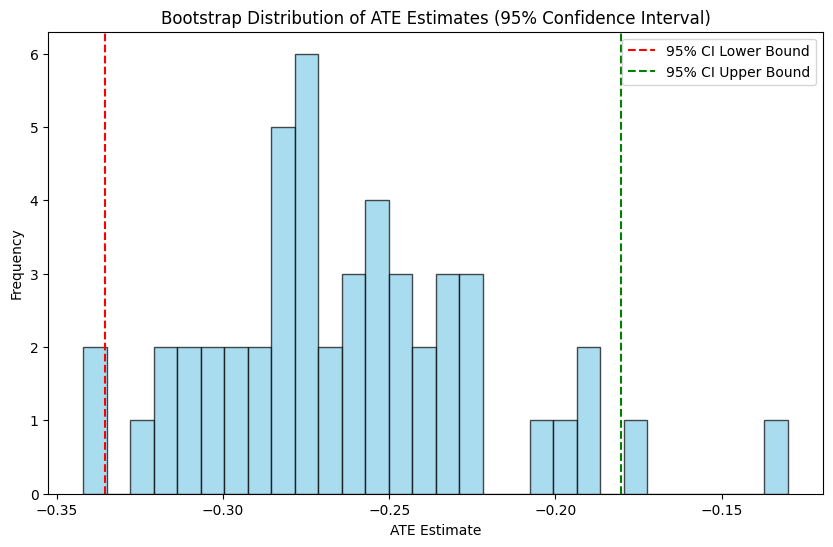

<ipython-input-11-16198e052ea0>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2, figsize=(14, 5))


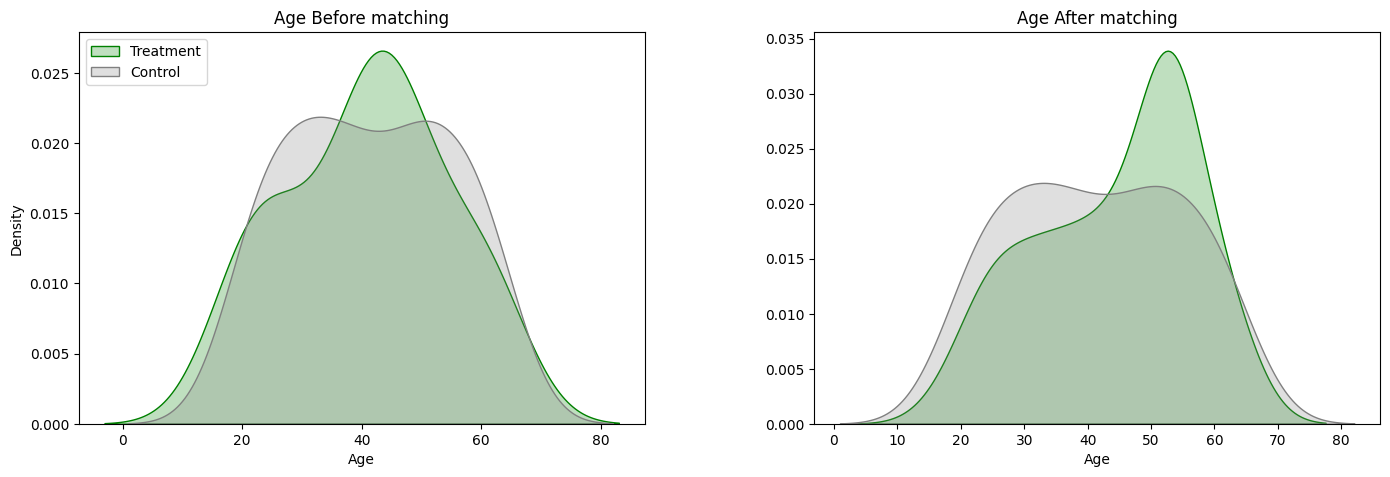

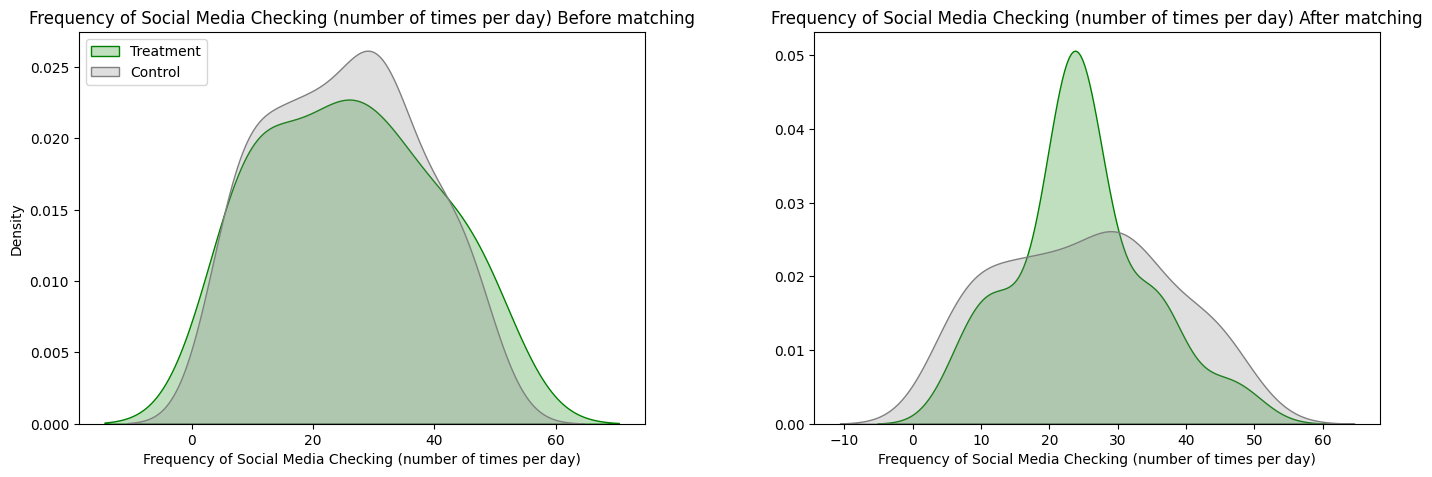

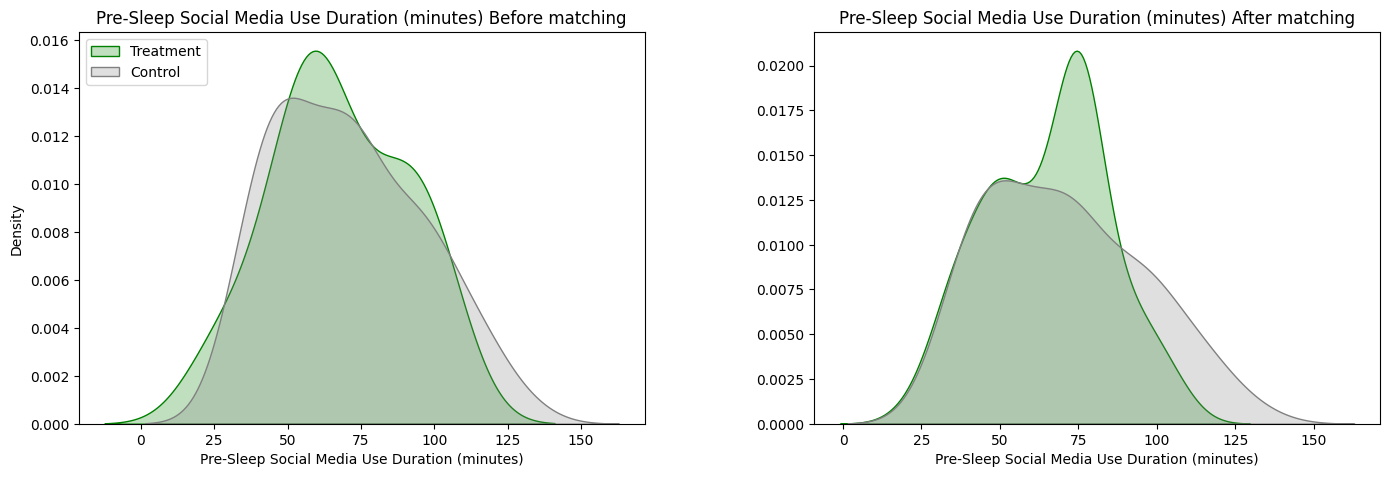

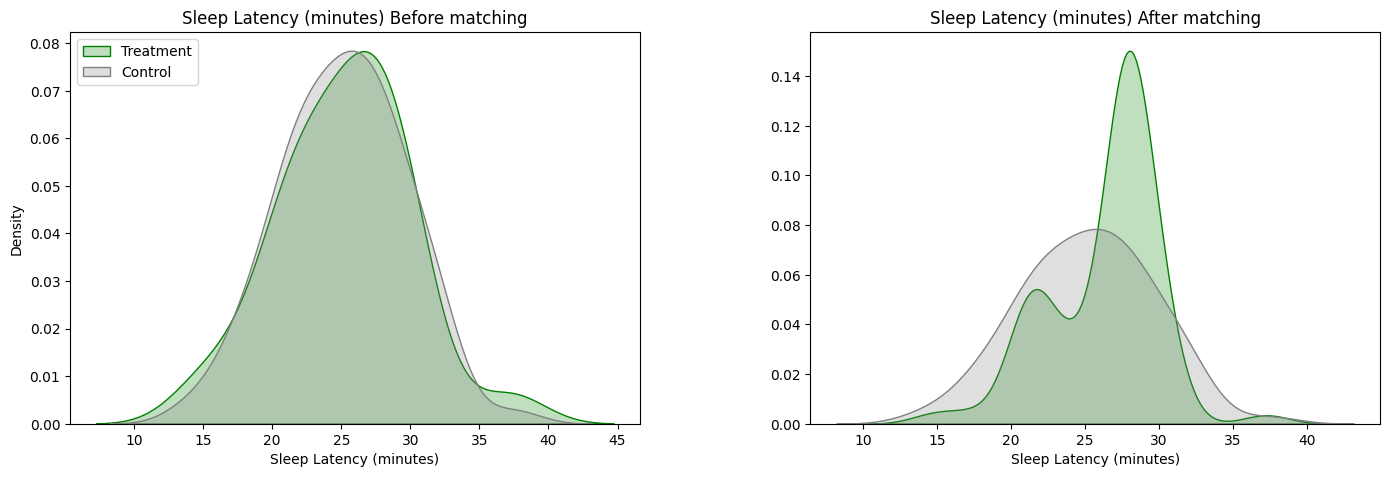

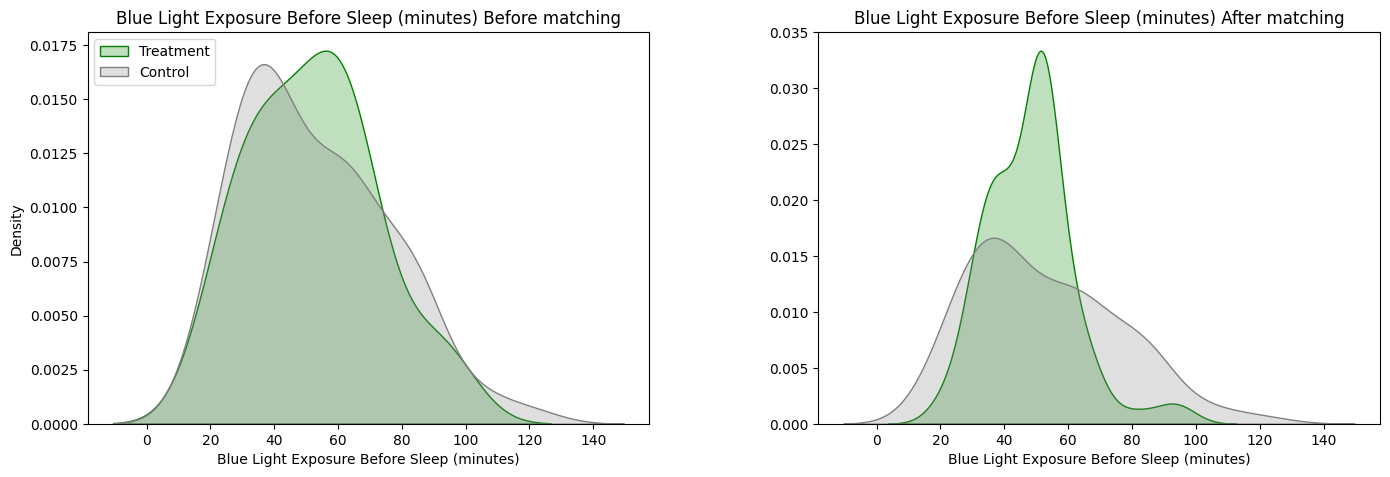

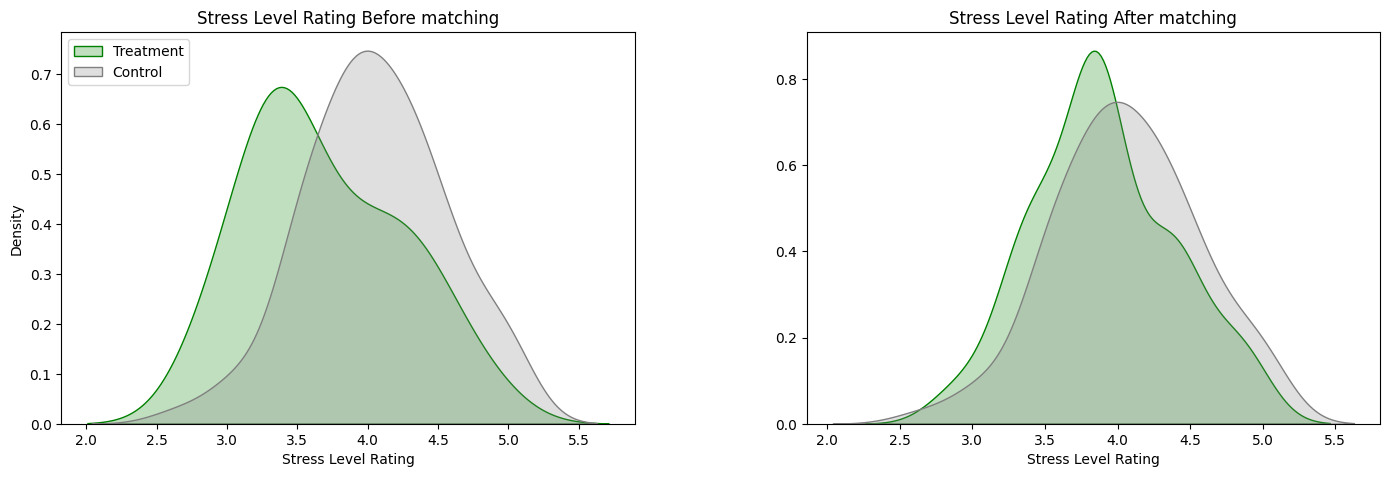

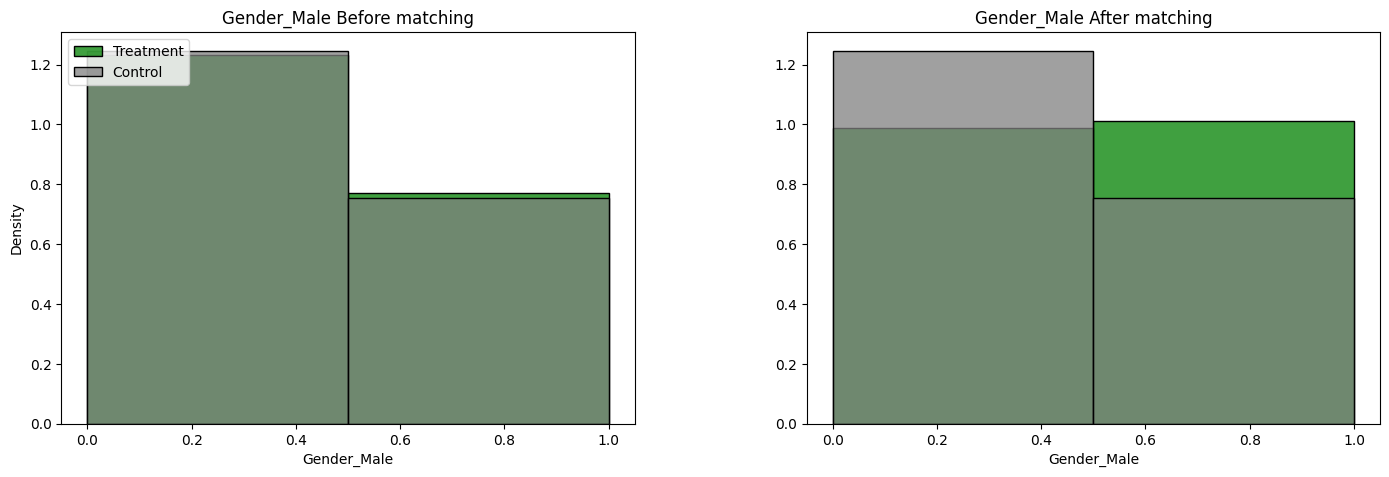

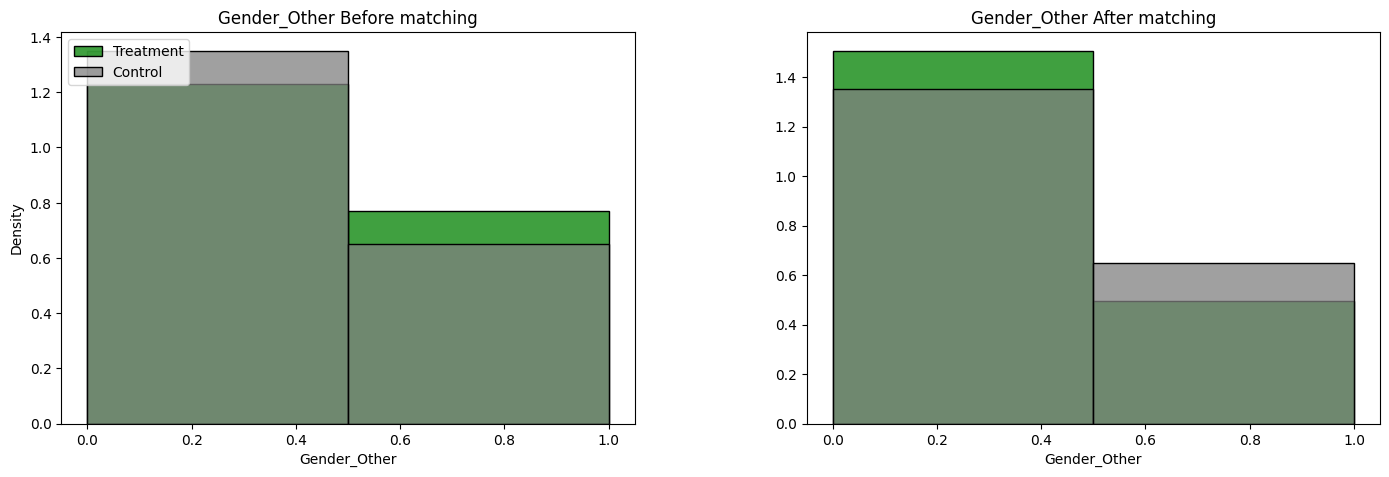

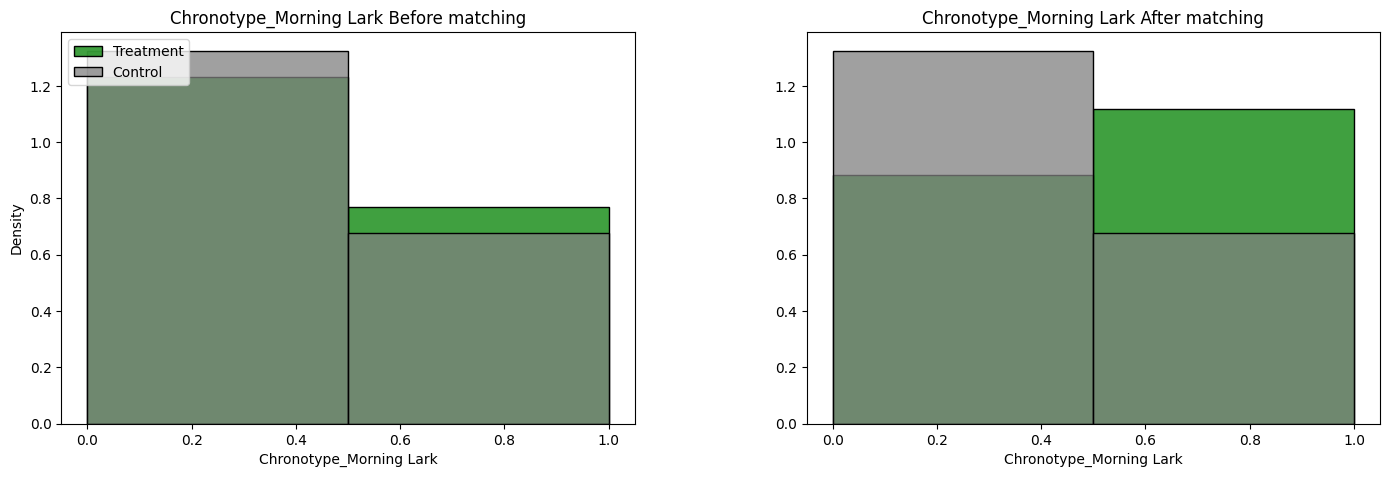

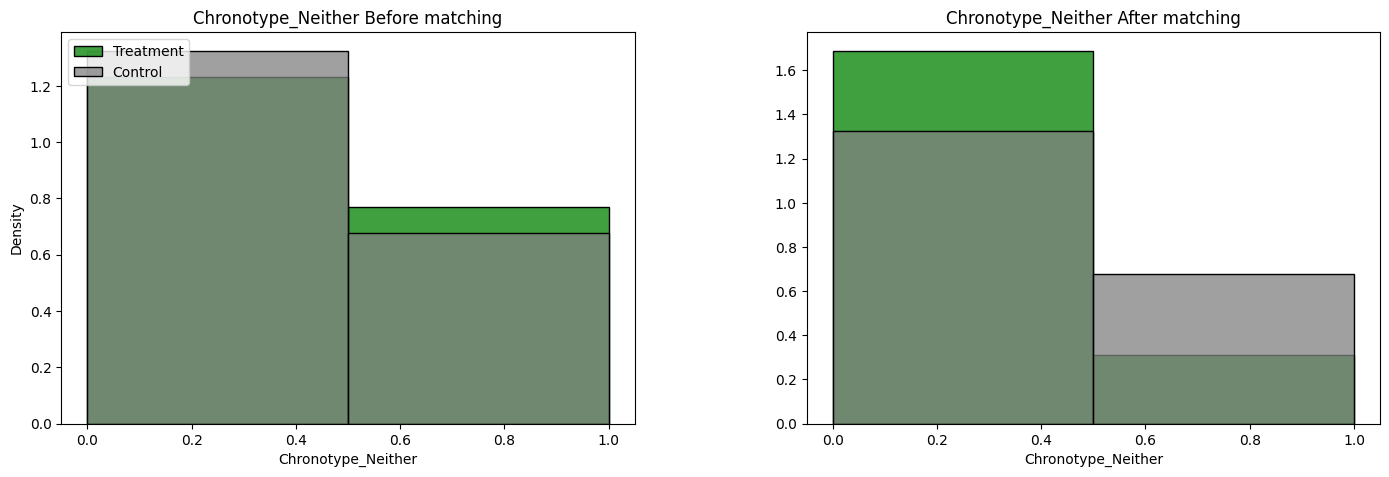

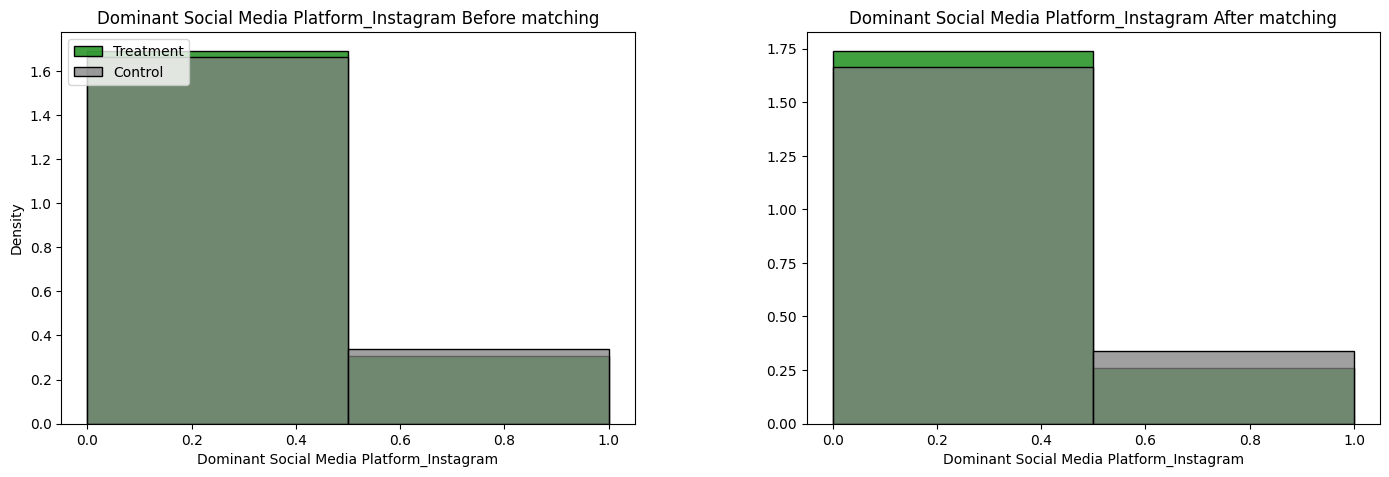

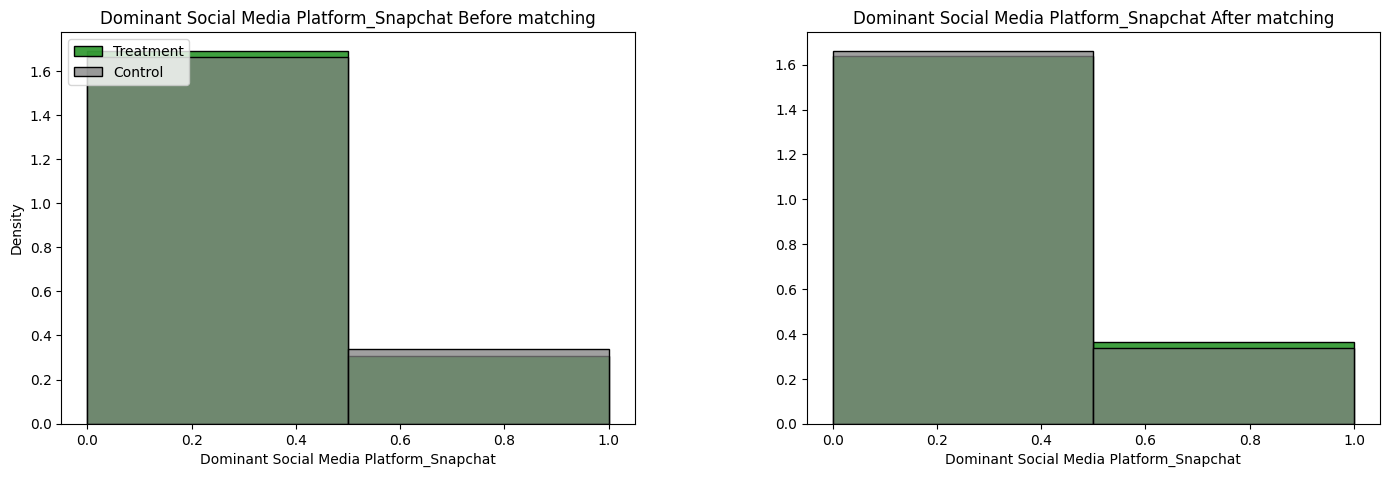

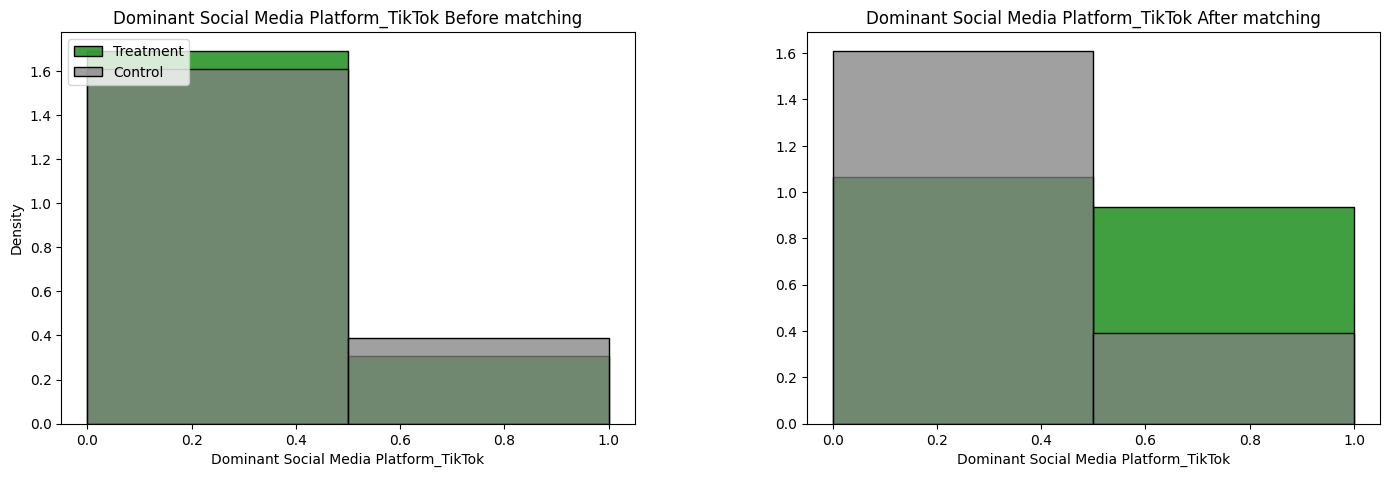

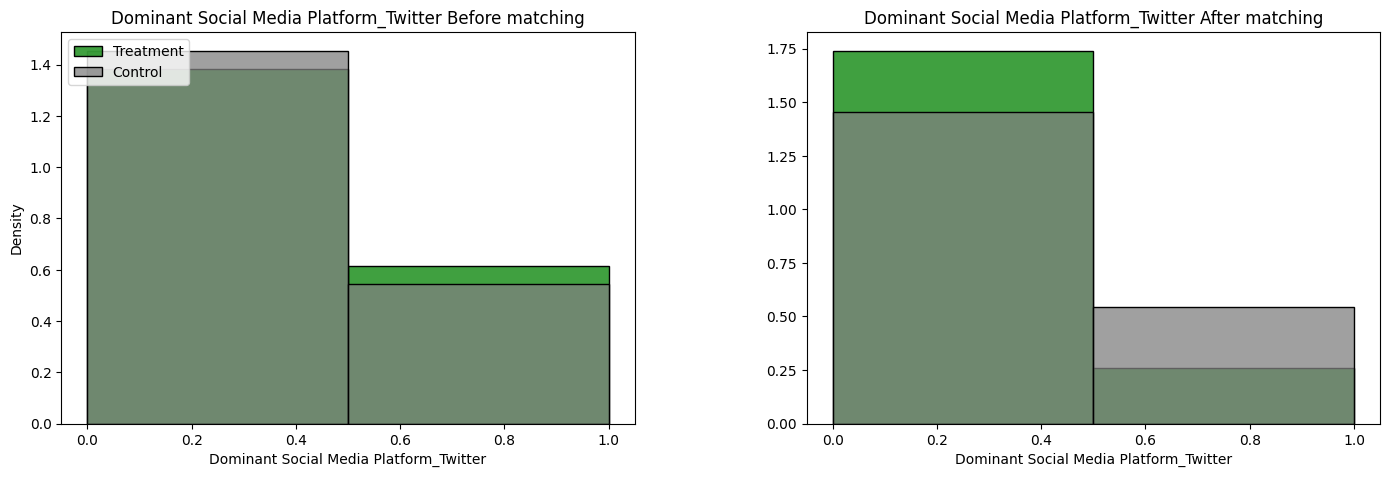

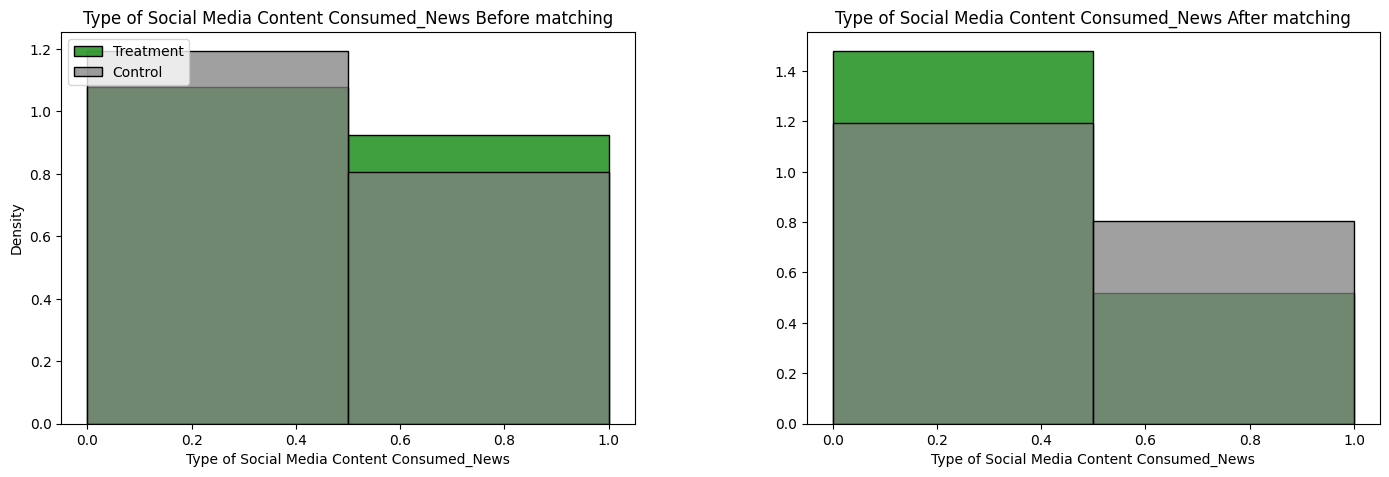

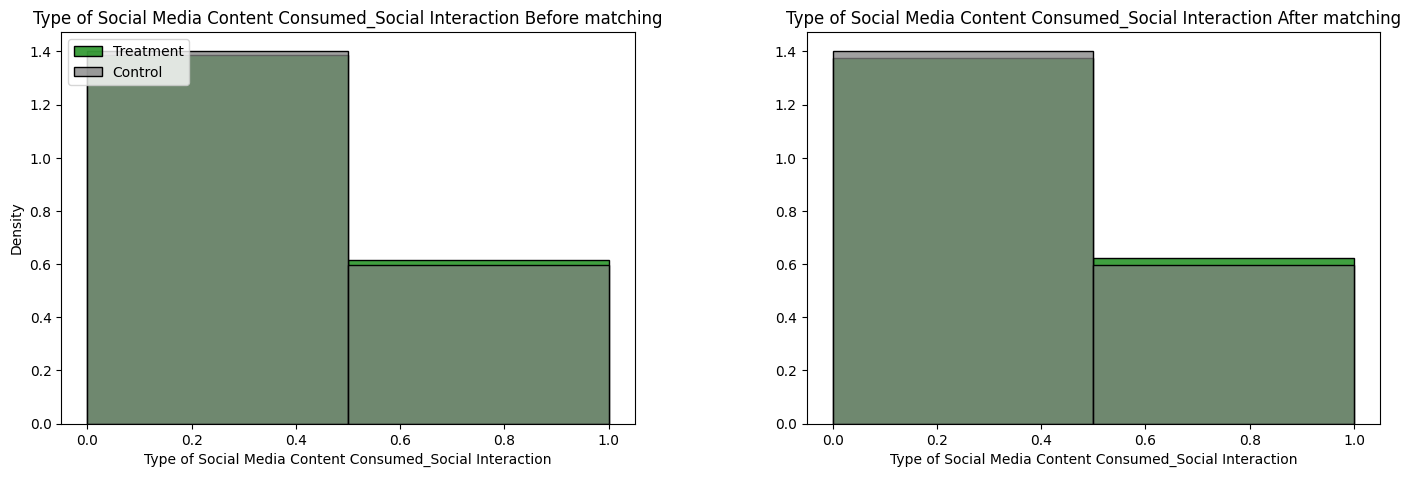

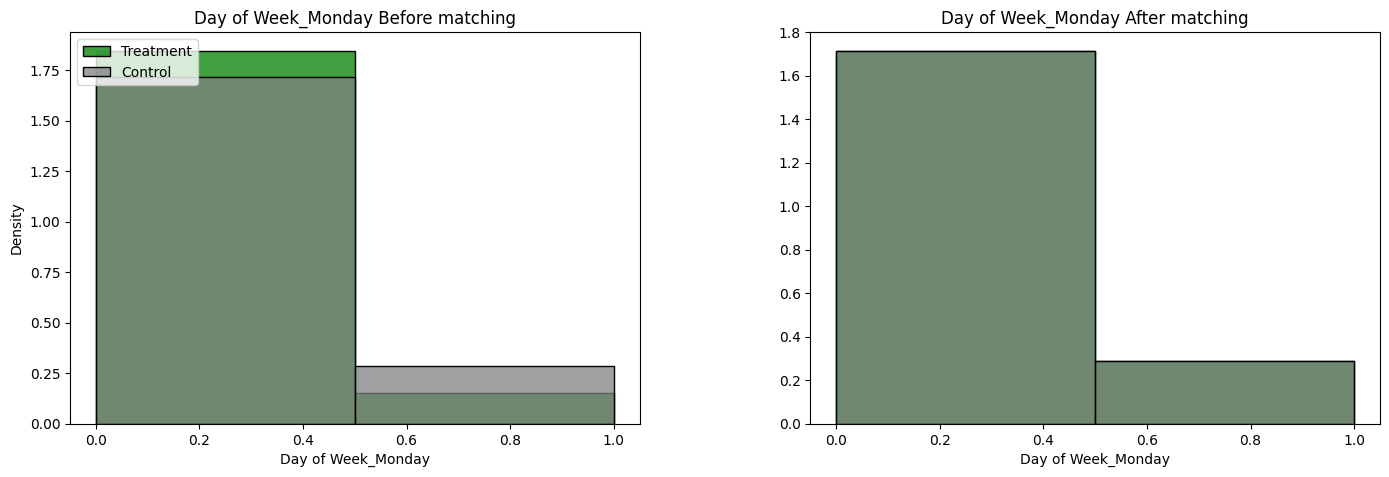

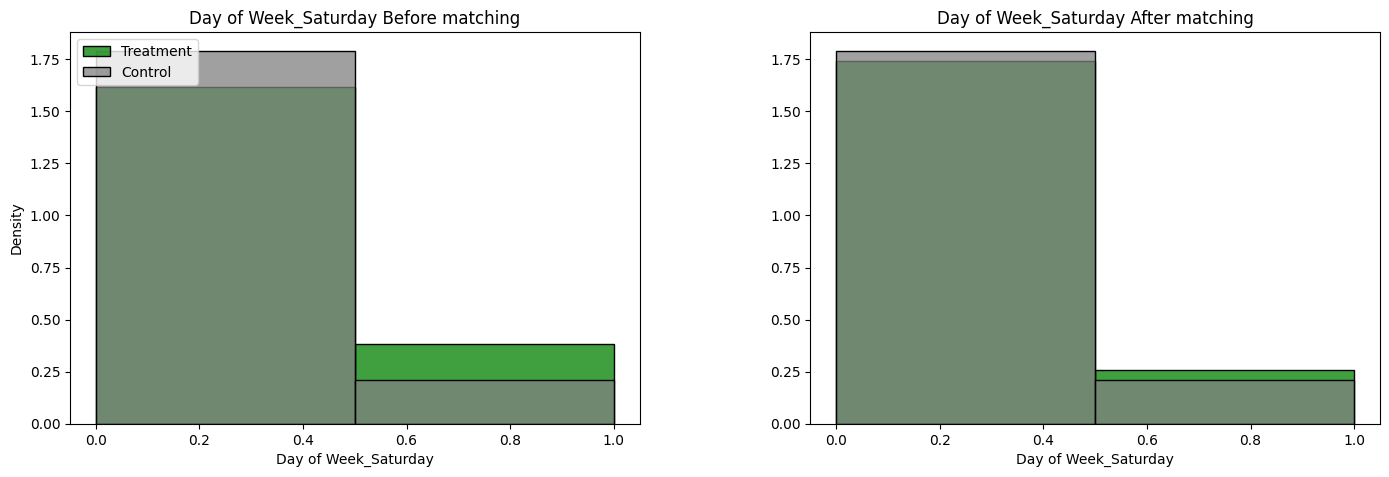

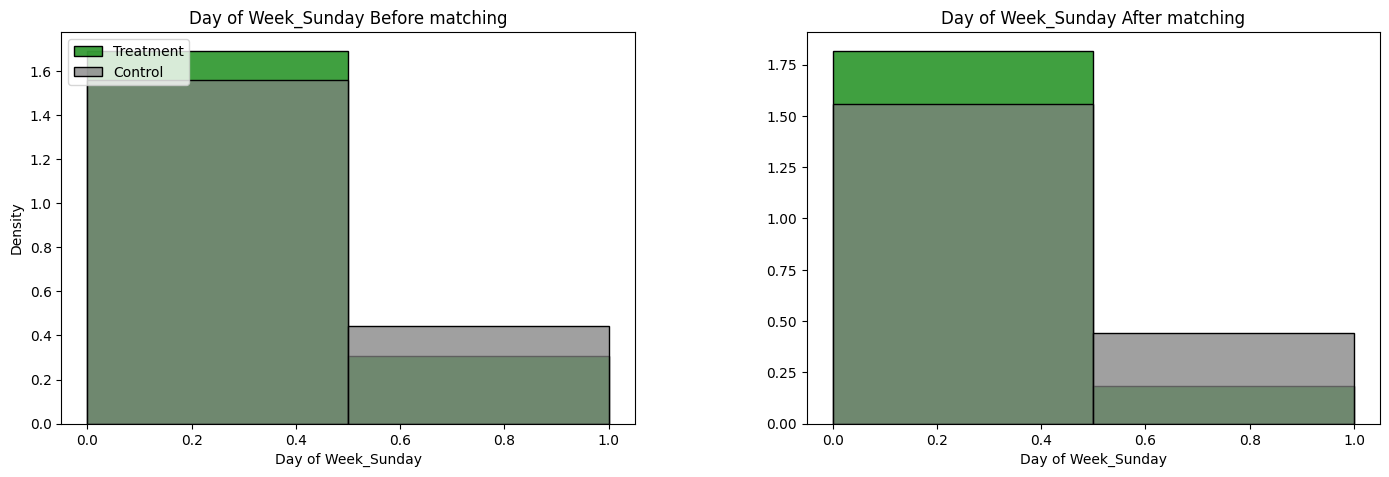

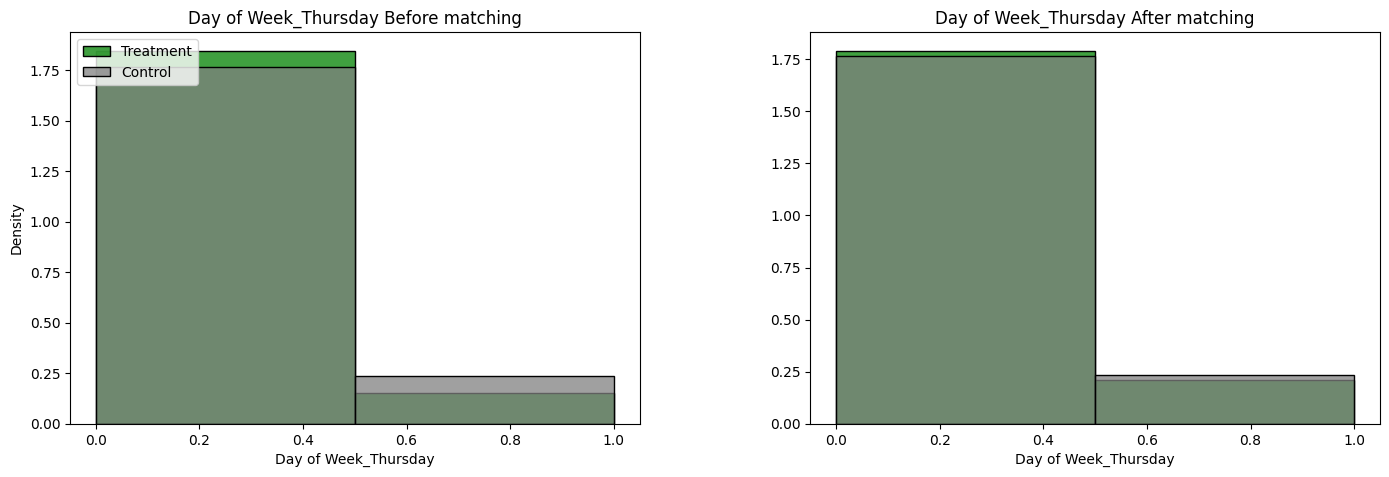

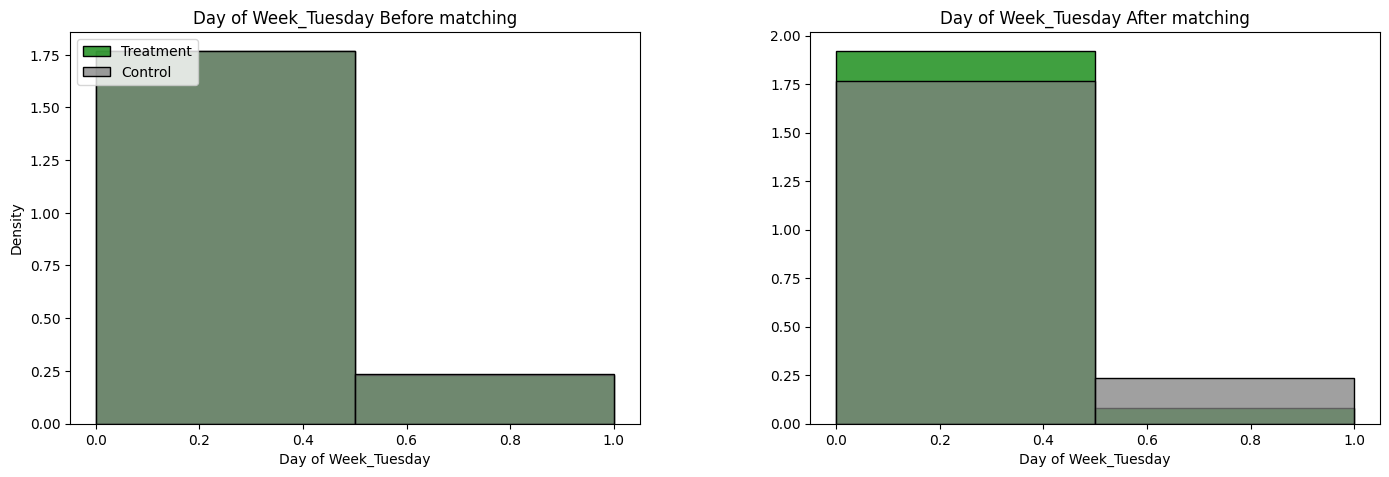

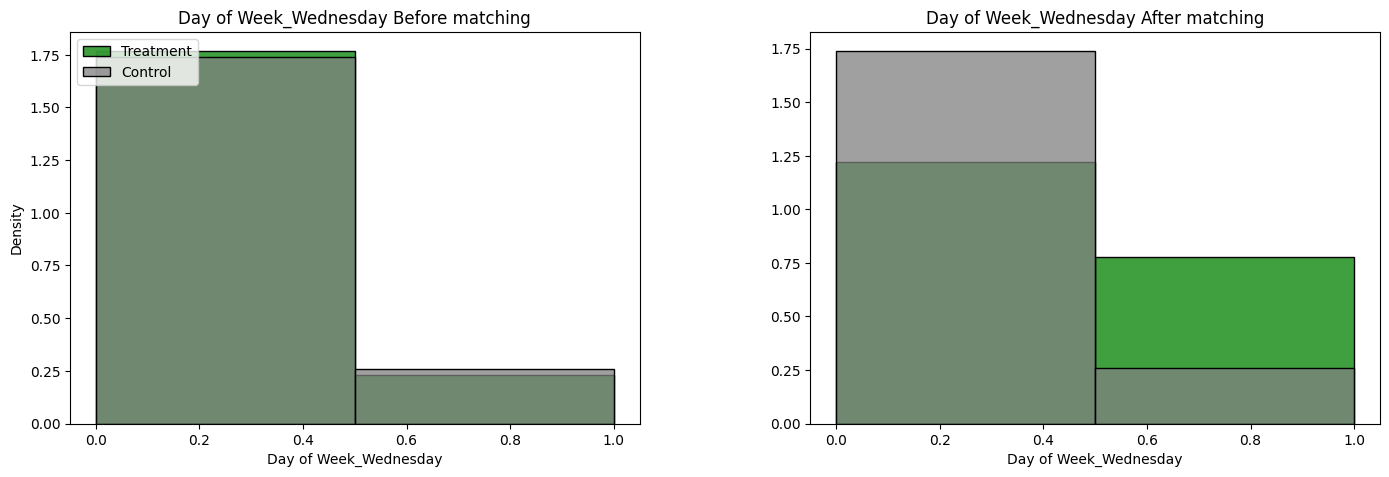

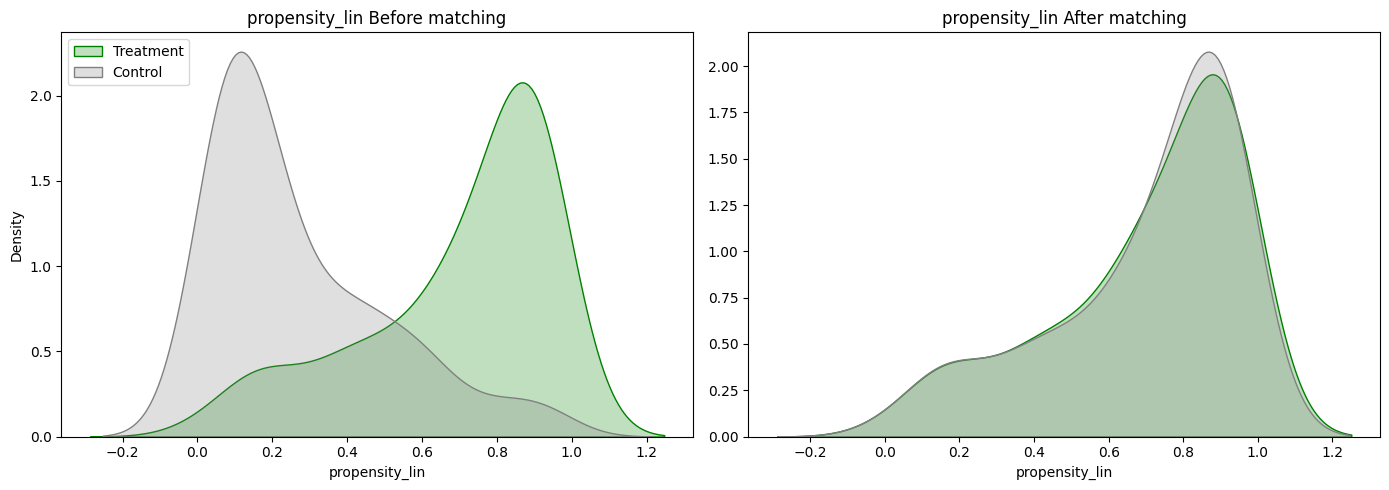

<----------------------Matching Covariates------------------------>
ATE using Covariates Matching: -0.22991269712849868
95% Confidence Interval for ATE using bootstrap: [-0.27724882960451624, -0.18274113143494847]


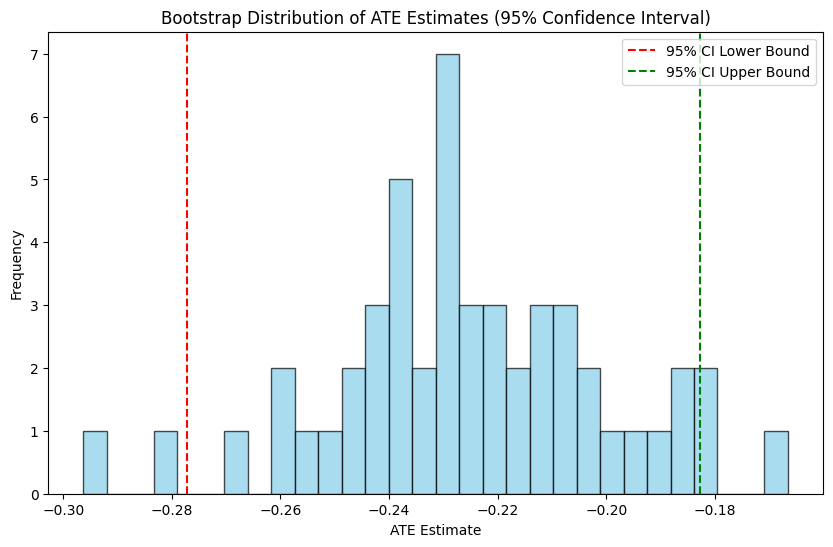

<ipython-input-11-16198e052ea0>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 2, figsize=(14, 5))


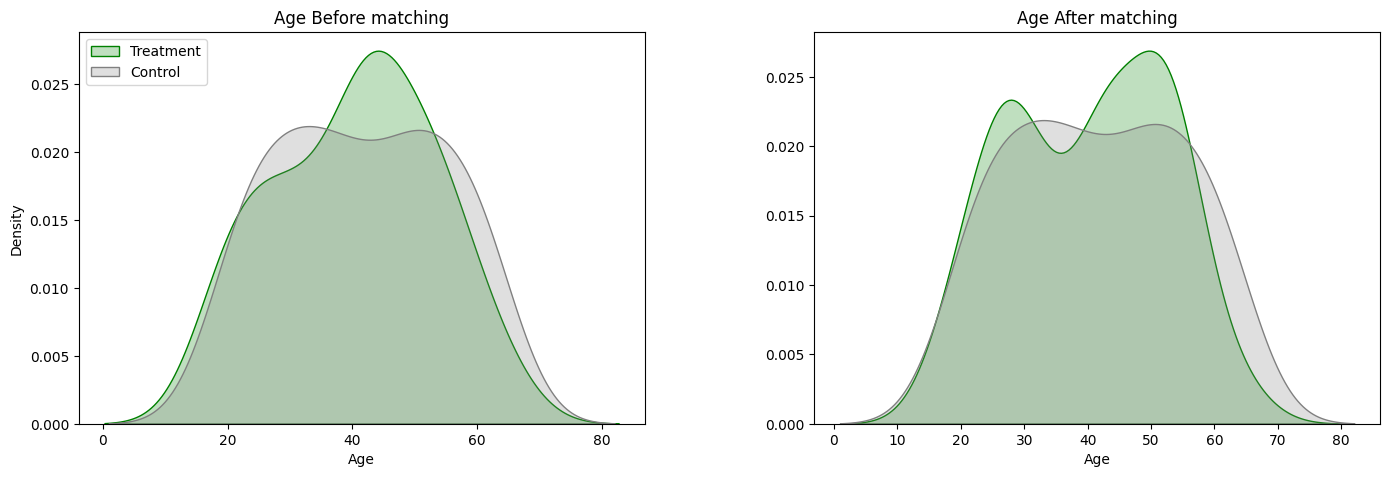

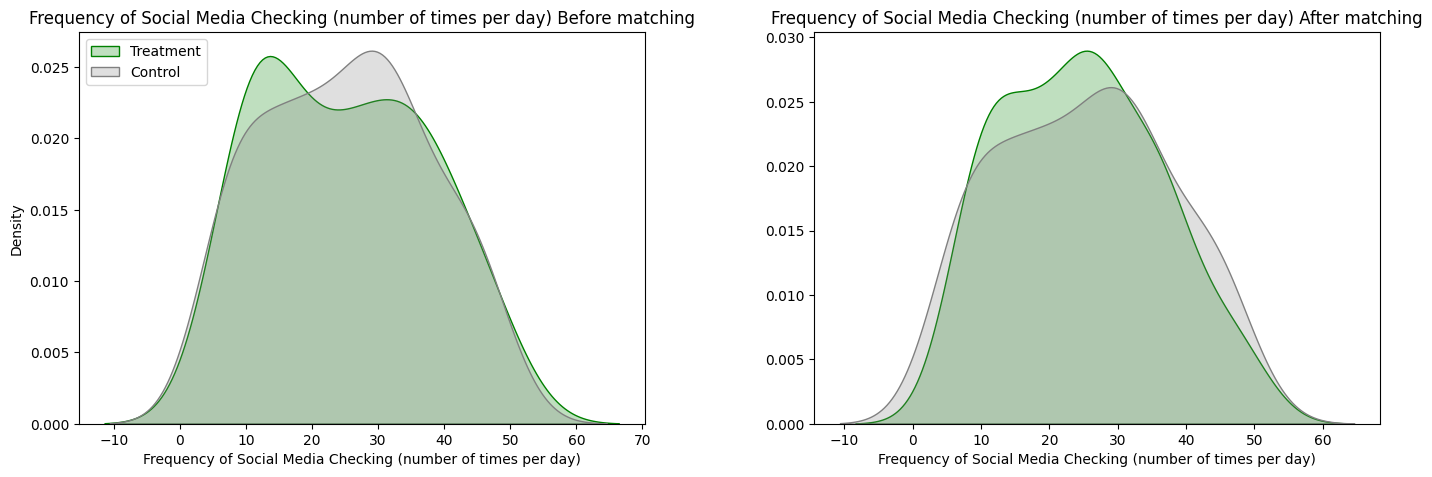

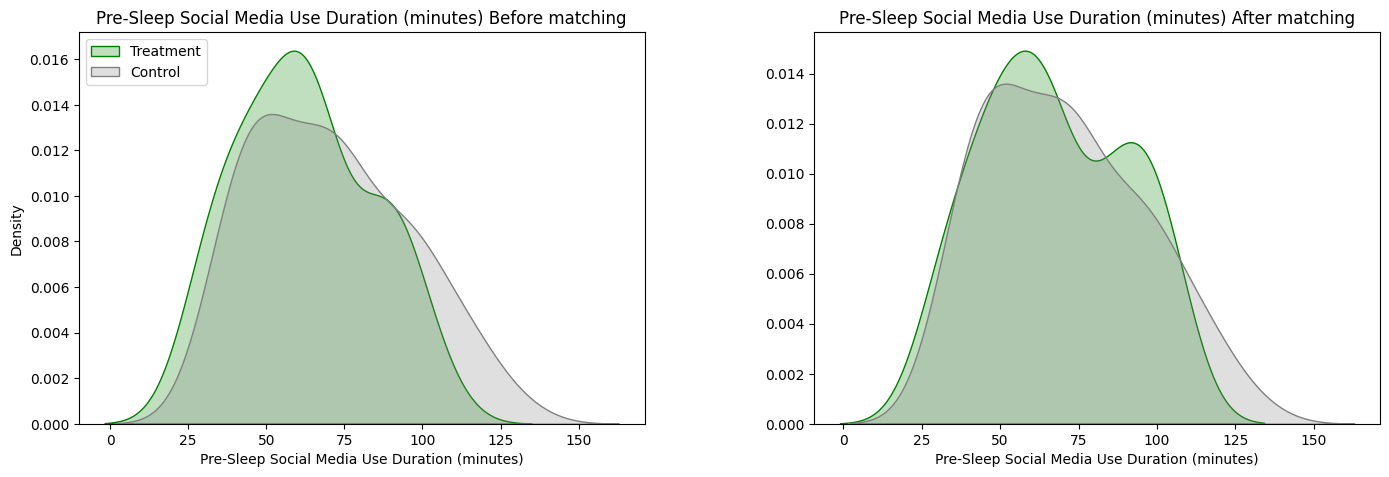

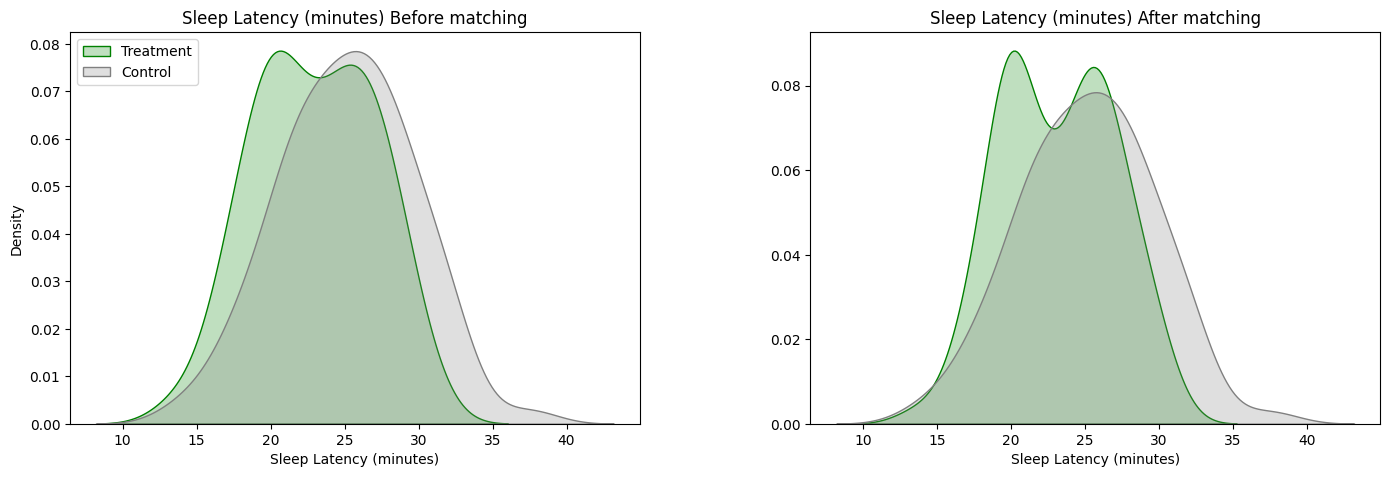

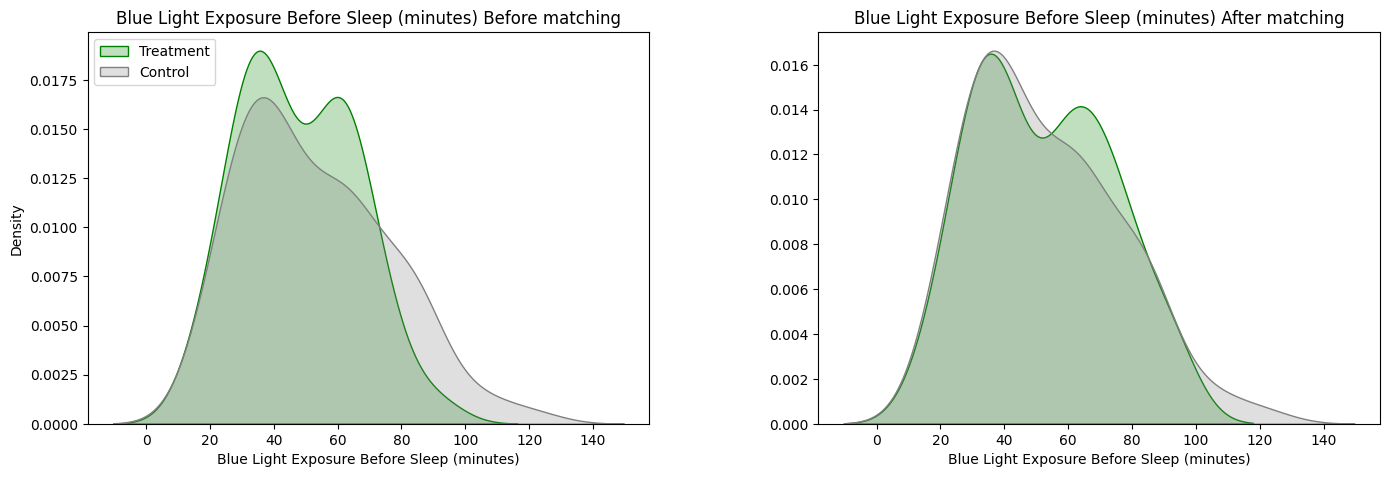

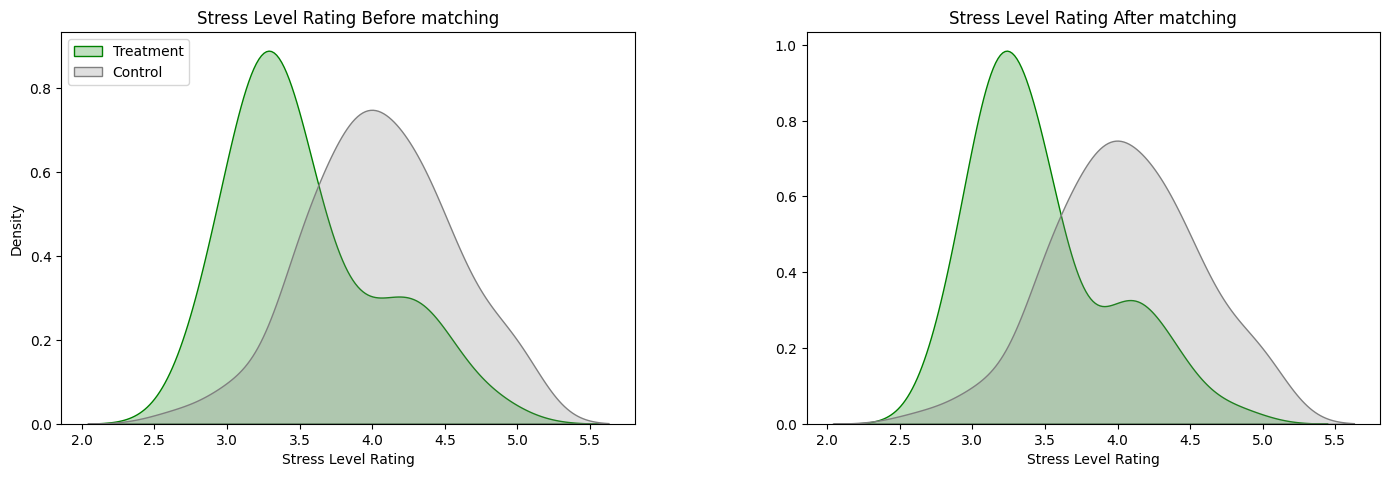

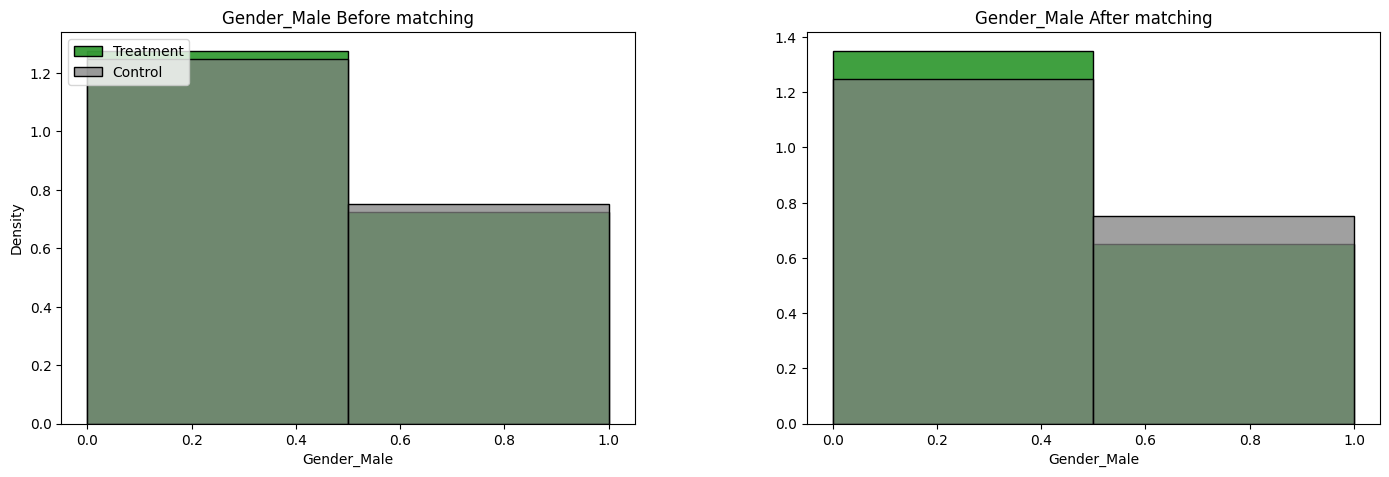

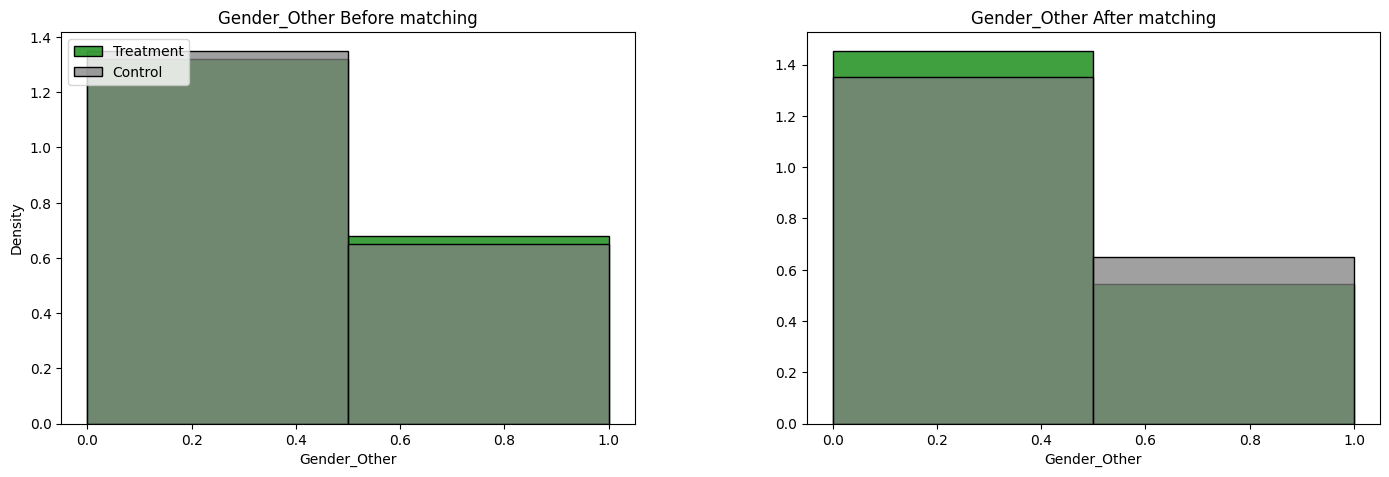

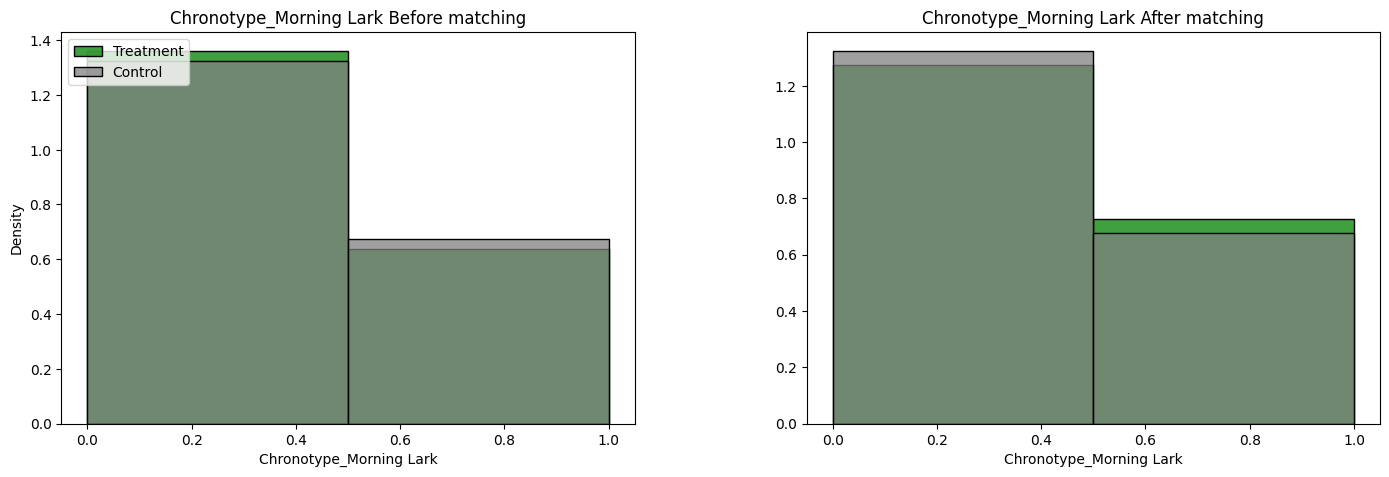

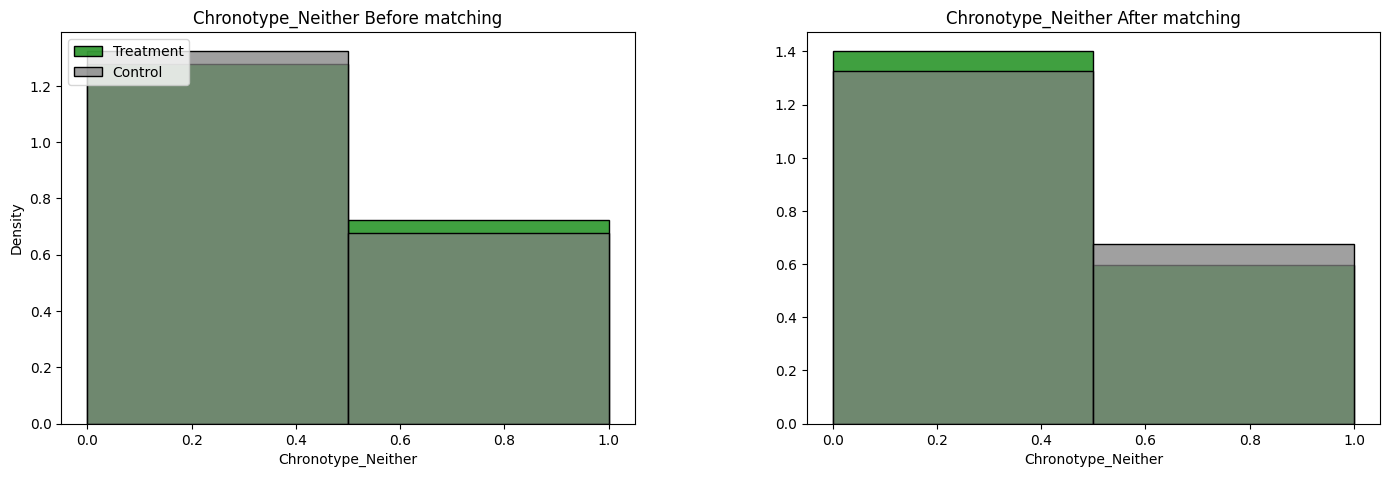

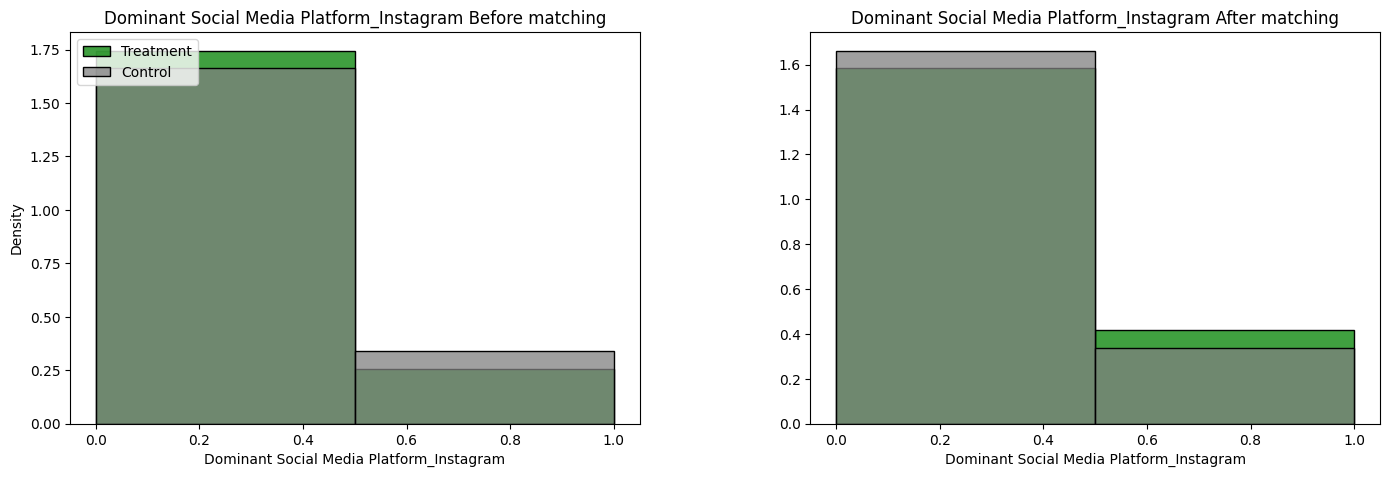

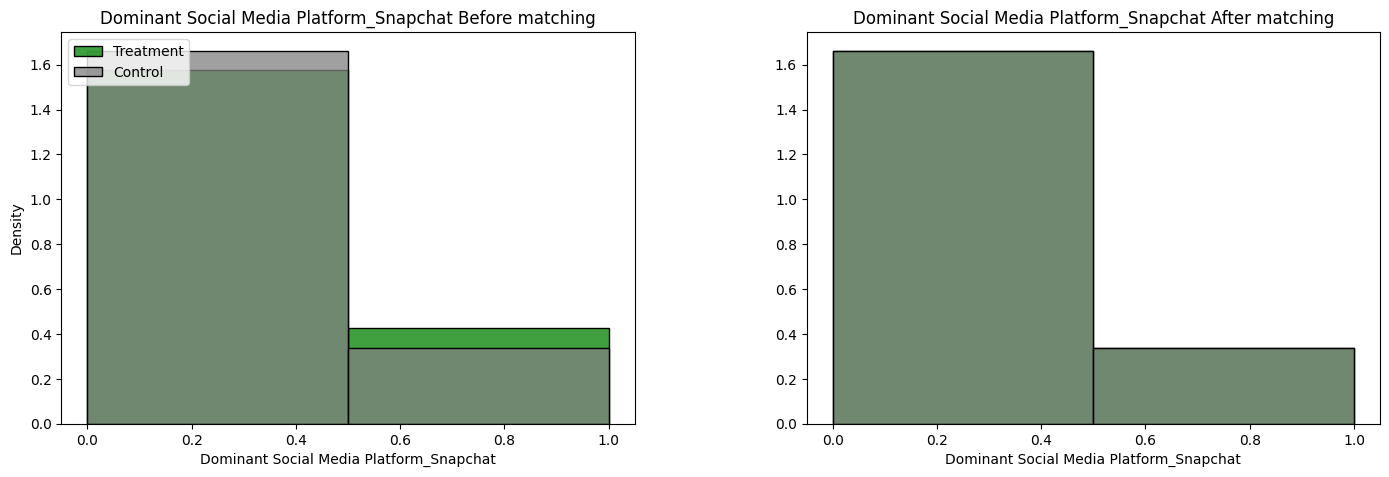

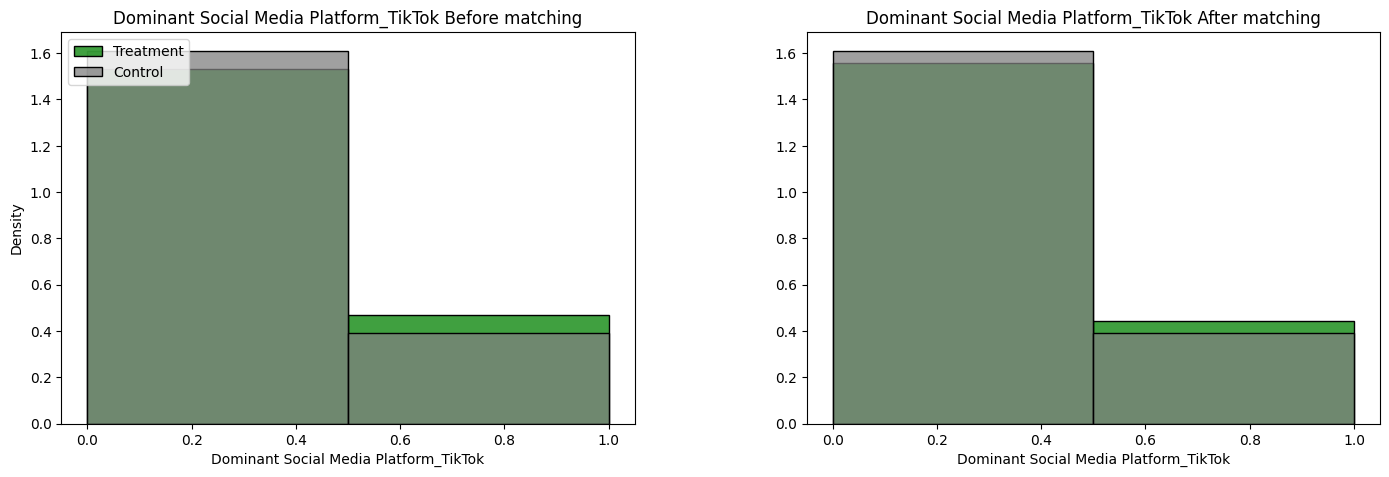

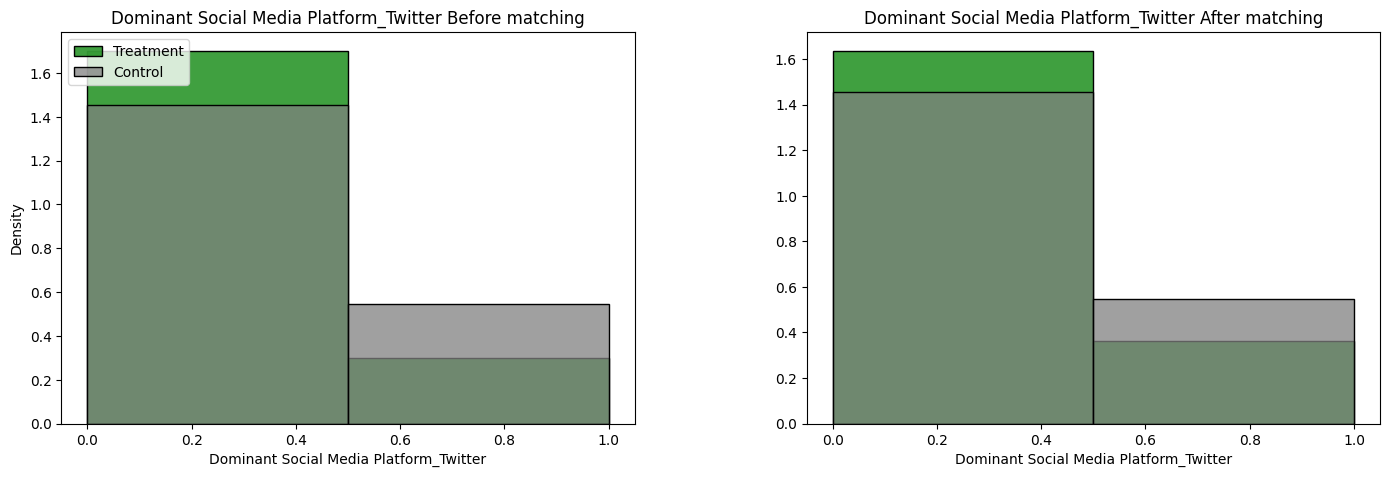

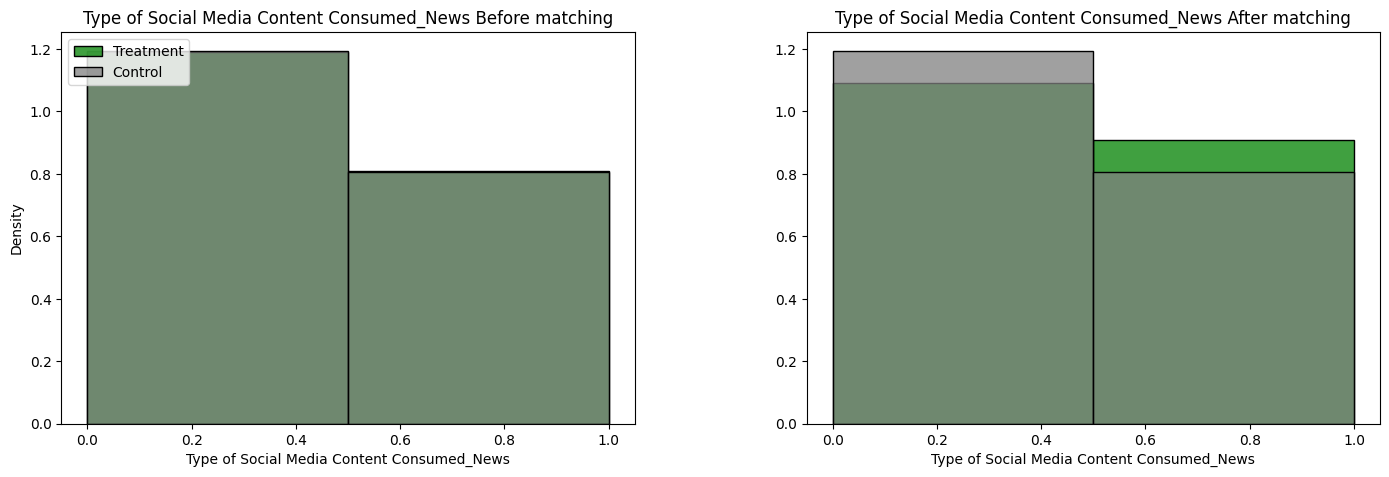

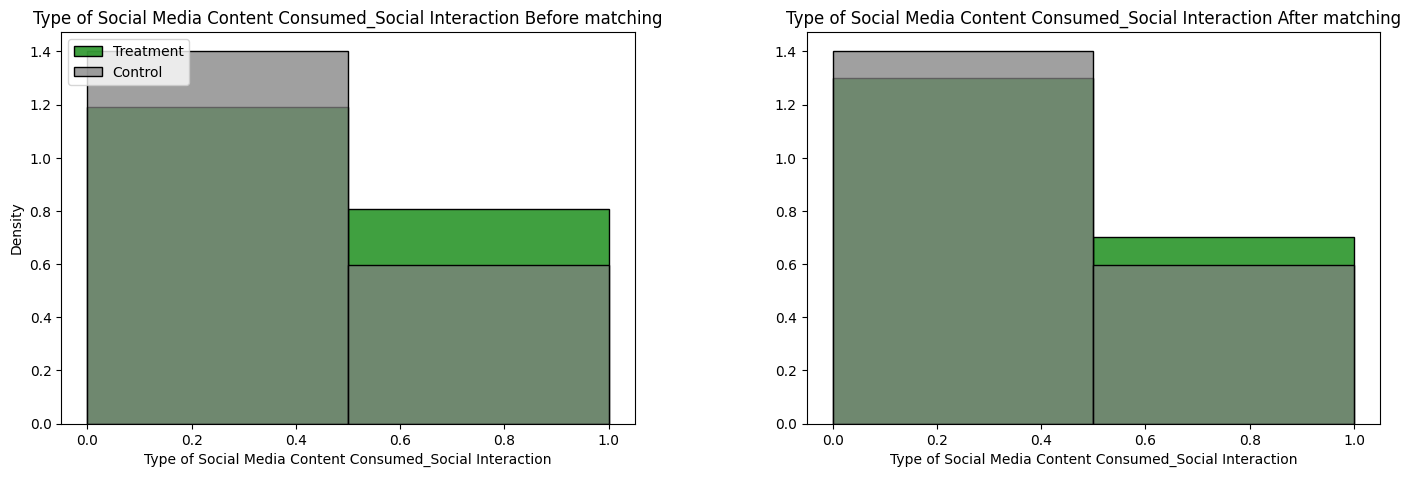

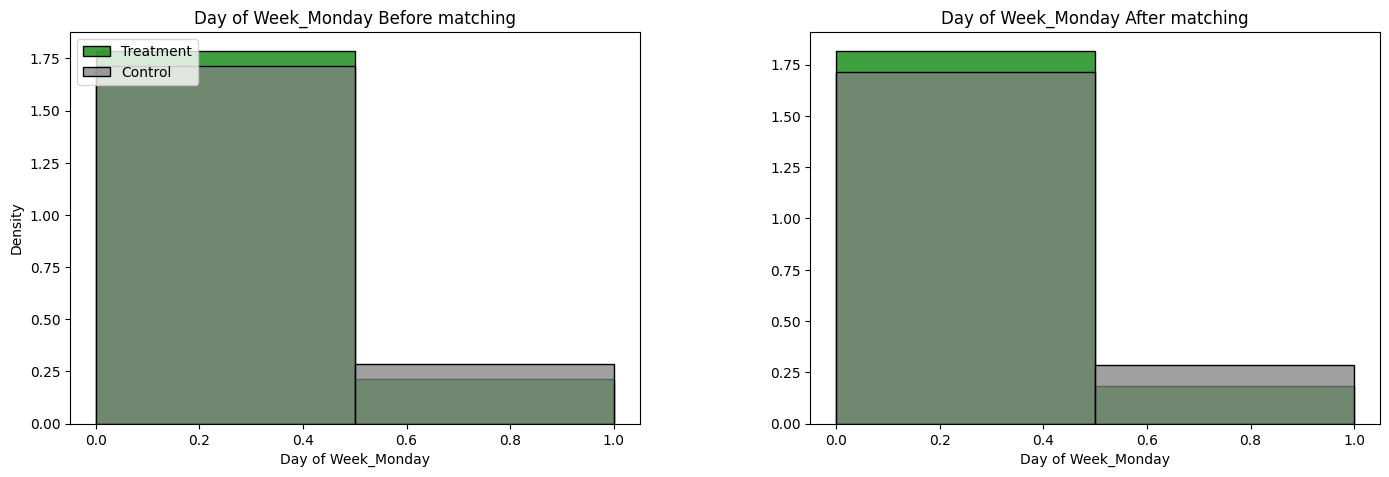

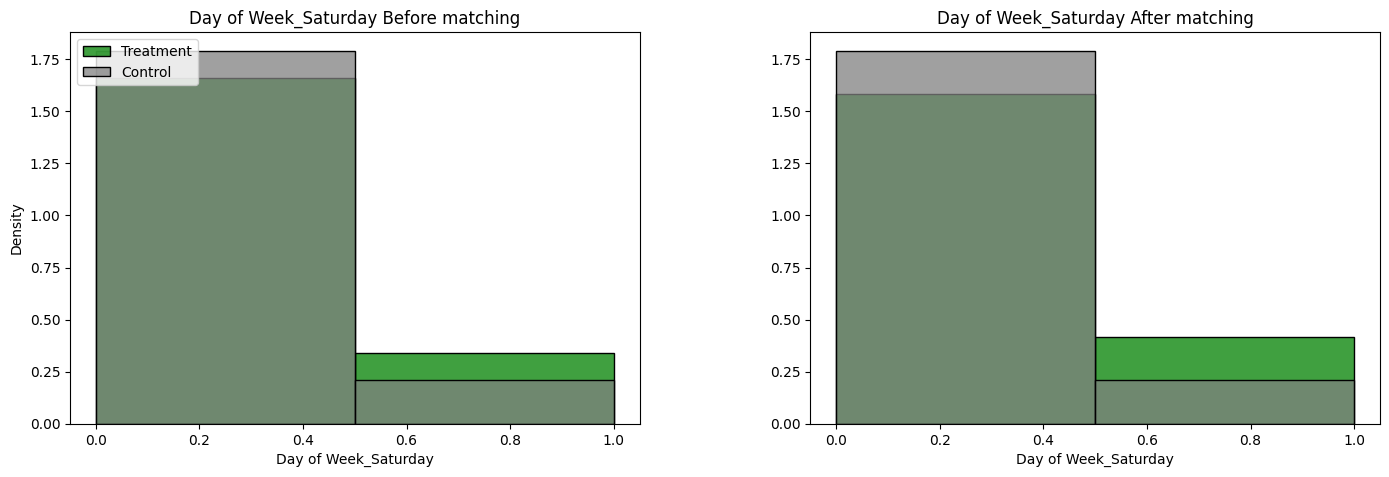

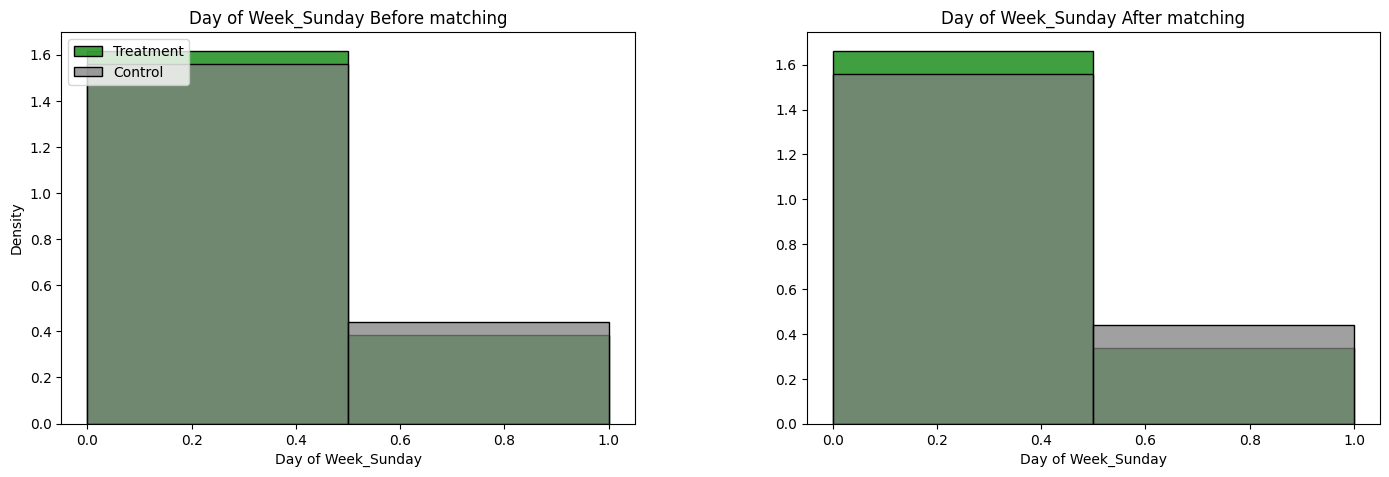

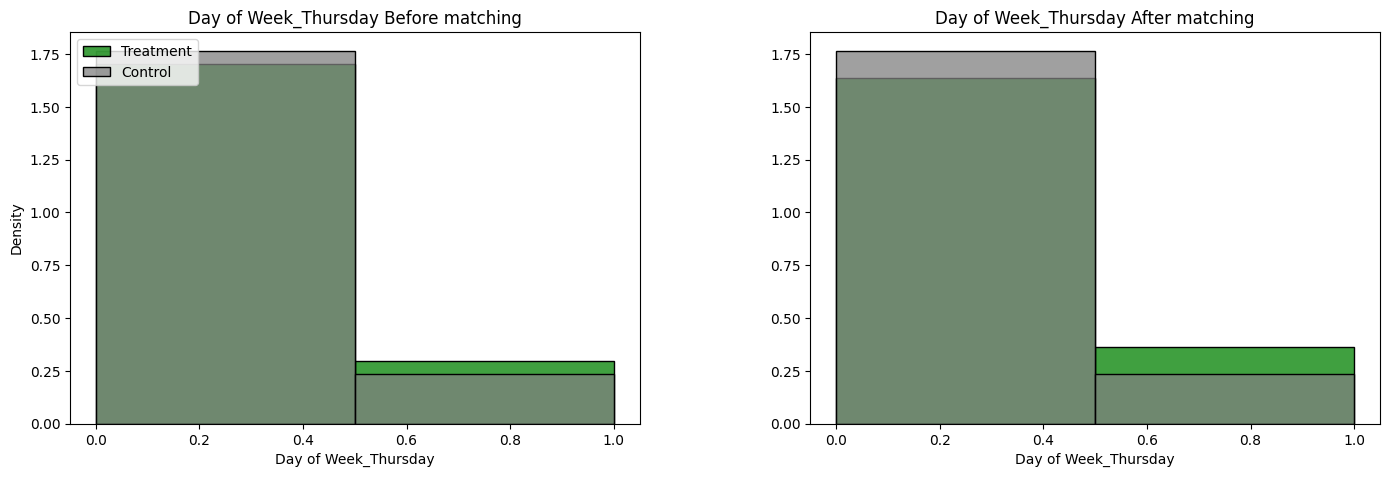

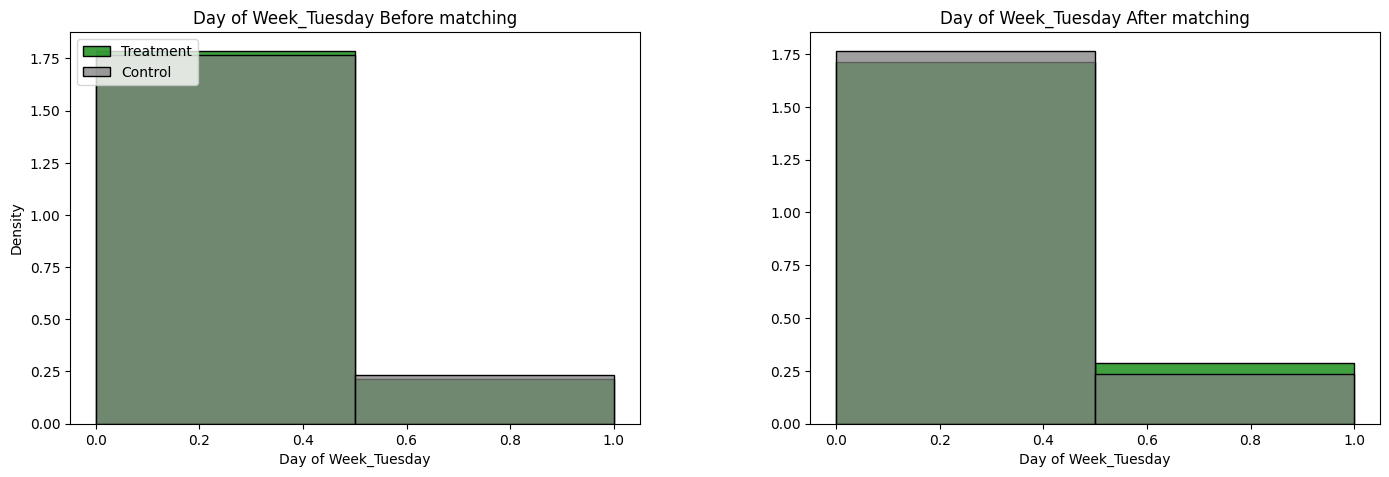

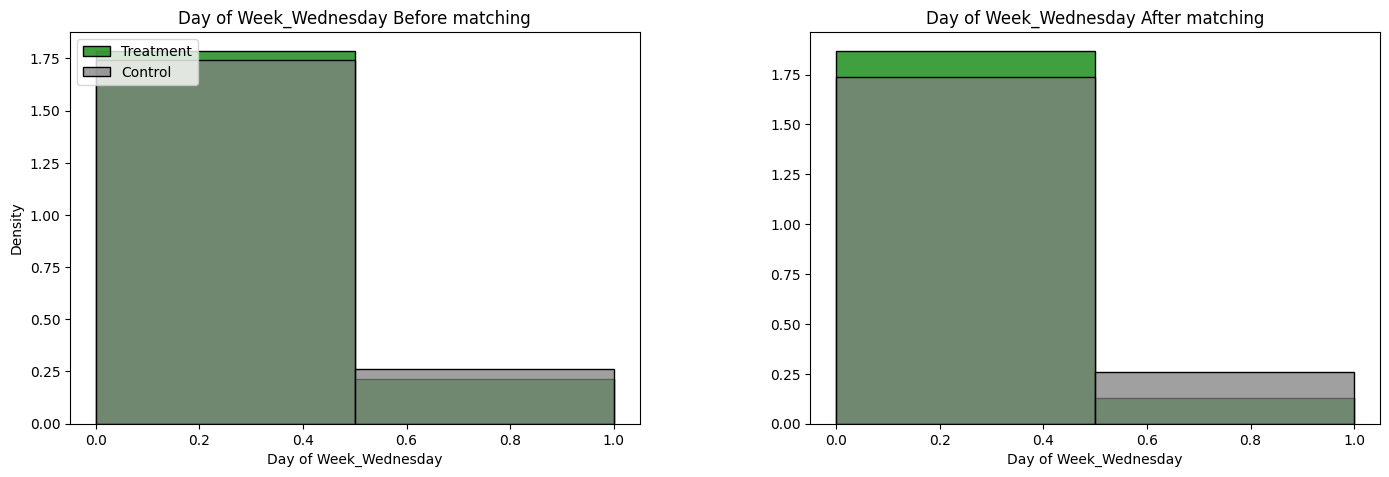

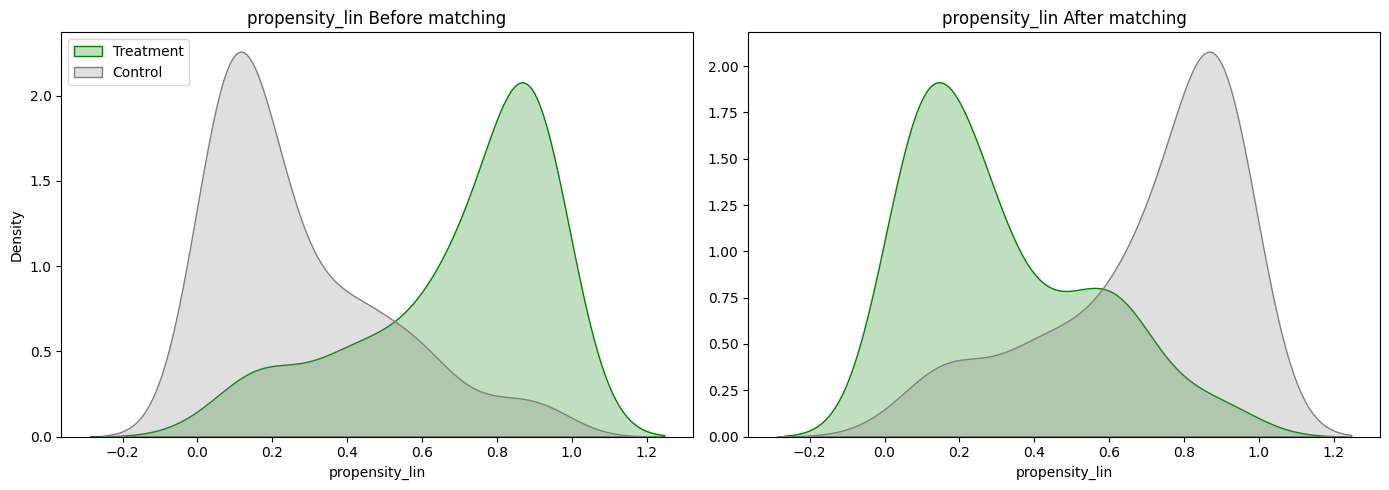

In [13]:
print("<----------------------Matching Propensity------------------------>")


# Calculate matching
ate_matching_prop, treated_pred_prop, control_pred_prop = propensity_score_matching(df_trimmed, predictions)
print(f"ATE using Propensity Matching: {ate_matching_prop}")

# Calculate bootstrap confidence intervals
ci_lower, ci_upper, bootstrap_ate_distribution = bootstrap_CI(df_trimmed, predictions=predictions ,method="Matching_prop")
print(f"{95}% Confidence Interval for ATE using bootstrap: [{ci_lower}, {ci_upper}]")
plot_bootstrap_distribution(bootstrap_ate_distribution, ci_lower, ci_upper, ci=95)

# Plot for Matching - Treated Group
plot_matches(df_trimmed, X_trimmed,treated_pred_prop, control_pred_prop)

print("<----------------------Matching Covariates------------------------>")


# Calculate matching
ate_matching_cov, treated_pred_cov, control_pred_cov = covariate_matching(df_trimmed, X_trimmed, predictions)
print(f"ATE using Covariates Matching: {ate_matching_cov}")

# Calculate bootstrap confidence intervals
ci_lower, ci_upper, bootstrap_ate_distribution = bootstrap_CI(df_trimmed, predictions=predictions ,method="Matching_cov", X_trimmed = X_trimmed)
print(f"{95}% Confidence Interval for ATE using bootstrap: [{ci_lower}, {ci_upper}]")
plot_bootstrap_distribution(bootstrap_ate_distribution, ci_lower, ci_upper, ci=95)

# Plot for Matching - Treated Group
plot_matches(df_trimmed, X_trimmed,treated_pred_cov, control_pred_cov)